In [2]:
import wandb

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import flops as fl
from wp import WPLinear
import utils

## Methods figures

### Basic perturbation figures

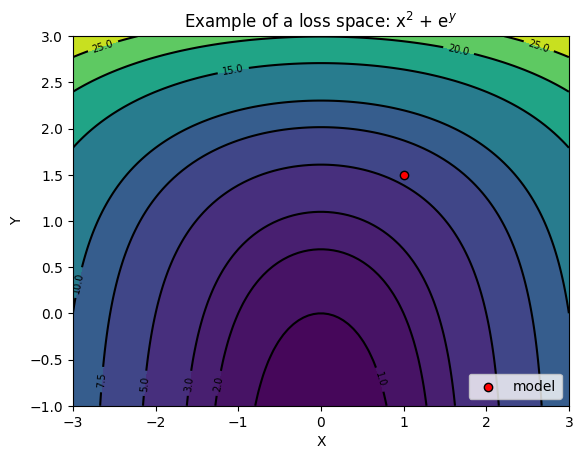

In [3]:
# Implementation of matplotlib functio

plt.rcParams["figure.dpi"] = 100
feature_x = np.linspace(-3, 3, 100) 
feature_y = np.linspace(-1, 3, 100) 

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y) 

fig, ax = plt.subplots(1, 1) 

Z = X ** 2 + Y ** 2 
Z = X**2 +  math.e**Y 

labels= [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
# labels = 10
# plots filled contour plot
ax.contourf(X, Y, Z, levels=labels)
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)

plt.scatter(1, 1.5, edgecolors="black", color="red", label="model")
plt.legend()
ax.set_title("Example of a loss space: x$^2$ + e$^y$ ")
ax.set_xlabel('X') 
ax.set_ylabel('Y') 


# https://lectures.scientific-python.org/advanced/mathematical_optimization/auto_examples/plot_convex.html
plt.show()


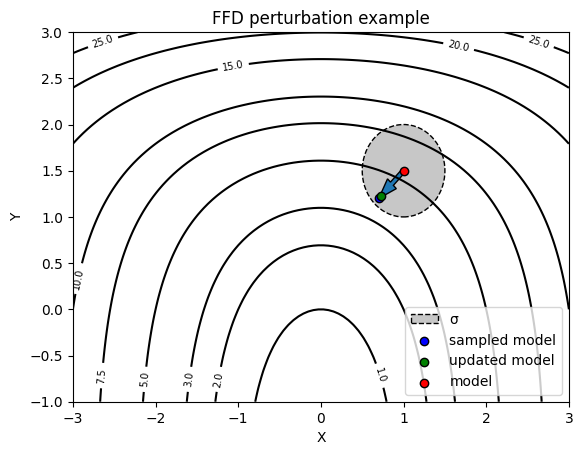

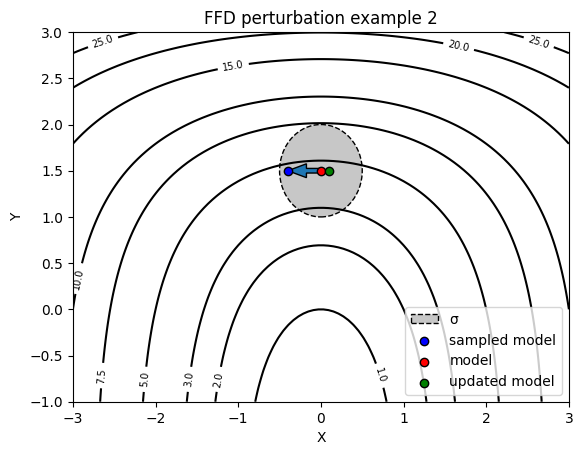

In [10]:
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

Z = X**2 + math.e**Y

xpos = 1
ypos = 1.5

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)

# original point [1, 1.5] -> loss = 5.4816
# new point [0.7, 1.2] -> loss = 3.81
# Update rule is -lr * n/size_pert^2 * (loss_dif * perturbation)
# -0.05 *    = -0.2786
#

circ = plt.Circle(
    (
        xpos,
        ypos,
    ),
    radius=0.5,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)


plt.arrow(x=xpos, y=ypos, dx=-0.3, dy=-0.3, width=0.05, length_includes_head=True)
plt.scatter(xpos-0.3, ypos-0.3, edgecolors="black", color="blue", label="sampled model")


# learning rate of 0.5

plt.scatter(
    xpos - 0.2786,
    ypos - 0.2786,
    edgecolors="black",
    color="green",
    label="updated model",
)
plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")


plt.legend()
ax.set_title("FFD perturbation example")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


# Second example
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

Z = X**2 + math.e**Y

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
# labels = 10
# plots filled contour plot

xpos = 0
ypos = 1.5
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


circ = plt.Circle(
    (
        xpos,
        ypos,
    ),
    radius=0.5,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)


plt.arrow(x=xpos, y=ypos, dx=-0.4, dy=0, width=0.05, length_includes_head=True)


# original point [0, 1.5] -> loss = 4.48169
# new point [-0.4, 1.5] -> loss = 4.64169
# Update rule is -lr/size_pert^2 * (loss_dif * perturbation)
# -0.05 * 2/((0.0)^2+(0.4)^2) * (4.48169-4.64169) * 0.4 = 0.2
#
#

plt.scatter(xpos - 0.4, ypos, edgecolors="black", color="blue", label="sampled model")
plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")

plt.scatter(
    xpos + 0.1,
    ypos,
    edgecolors="black",
    color="green",
    label="updated model",
)

plt.legend()
ax.set_title("FFD perturbation example 2")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

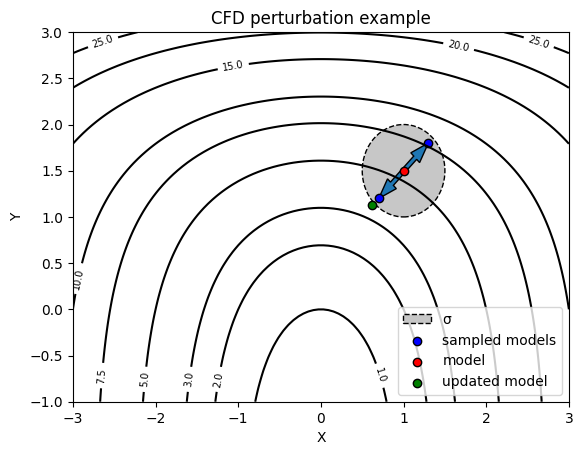

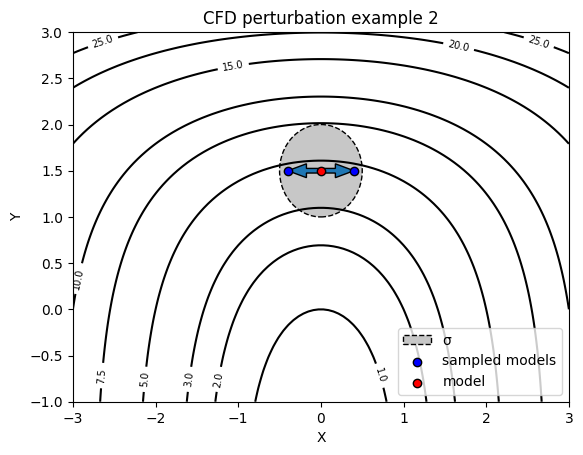

In [11]:
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

xpos=1
ypos=1.5
Z = X**2 + math.e**Y

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
# labels = 10
# plots filled contour plot
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


circ = plt.Circle(
    (
        xpos,
        ypos,
    ),
    radius=0.5,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)

plt.arrow(x=xpos, y=ypos, dx=-0.3, dy=-0.3, width=0.05, length_includes_head=True)
plt.arrow(x=xpos, y=ypos, dx=0.3, dy=0.3, width=0.05, length_includes_head=True)
plt.scatter([xpos+0.3, xpos-0.3], [ypos+0.3, ypos-0.3], edgecolors="black", color="blue", label="sampled models")

# original point [1, 1.5] -> loss = 5.4816
# new point [0.7, 1.2] -> loss = 3.81
# other point [1.3, 1.8] -> loss = 7.73965

# Update rule is -lr * n/size_pert^2 * (loss_dif * perturbation)
# -0.05 * 2/((0.3)^2+(0.3)^2) * (5.4816-7.73965) * 0.3 = -0.376


plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")
plt.scatter(
    xpos - 0.376, ypos - 0.376, edgecolors="black", color="green", label="updated model"
)

plt.legend()
ax.set_title("CFD perturbation example")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


# Second example
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

Z = X**2 + Y**2
Z = X**2 + math.e**Y

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
# labels = 10
# plots filled contour plot

xpos = 0
ypos = 1.5
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


circ = plt.Circle(
    (
        xpos,
        ypos,
    ),
    radius=0.5,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)

plt.arrow(x=xpos, y=ypos, dx=-0.4, dy=0, width=0.05, length_includes_head=True)
plt.arrow(x=xpos, y=ypos, dx=0.4, dy=0, width=0.05, length_includes_head=True)
plt.scatter(
    [xpos + 0.4, xpos - 0.4],
    [ypos, ypos],
    edgecolors="black",
    color="blue",
    label="sampled models",
)


# learning rate of 0.1


plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")

plt.legend()
ax.set_title("CFD perturbation example 2")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

### Multiple perturbations

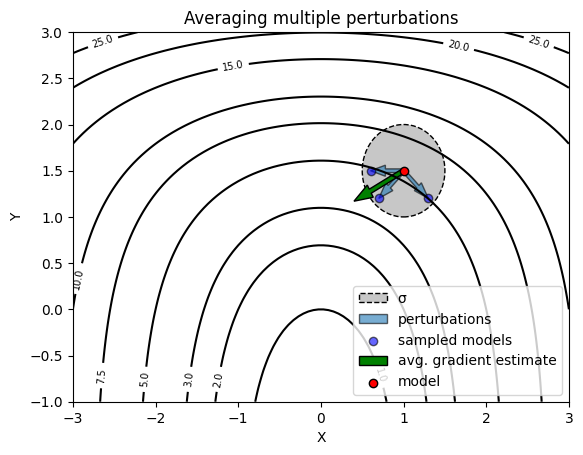

In [14]:
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

Z = X**2 + math.e**Y

xpos = 1
ypos = 1.5

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


circ = plt.Circle(
    (
        xpos,
        ypos,
    ),
    radius=0.5,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)


plt.arrow(
    x=xpos,
    y=ypos,
    dx=-0.4,
    dy=0,
    width=0.04,
    length_includes_head=True,
    alpha=0.6,
    label="perturbations",
)
plt.arrow(x=xpos, y=ypos, dx=-0.3, dy=-0.3, width=0.04, length_includes_head=True, alpha=0.6)
plt.arrow(x=xpos, y=ypos, dx=0.3, dy=-0.3, width=0.04, length_includes_head=True, alpha=0.6)


plt.scatter(
    [xpos -0.4, xpos + 0.3, xpos-0.3],
    [ypos, ypos-0.3, ypos-0.3],
    alpha=0.6,
    edgecolors="black",
    color="blue",
    label="sampled models",
)

# original point [1, 1.5] -> loss = 5.48
# new point 1 [0.6, 1.5] -> loss = 4.84
# new point 2 [0.7, 1.2] -> loss = 3.81
# new point 3 [1.3, 1.2] -> loss = 5.01
# Update rule is -lr *  sum ( n/size_pert^2 * (loss_dif * perturbation) ) / num_perts
#
# Point 1 update - n/size_pert^2 * (loss_dif * perturbation)
# dx = 2/(0.4^2) * (5.4816-4.84) * -0.4 = -3.208
# dy = 0
# Point 2 update - n/size_pert^2 * (loss_dif * perturbation)
# 2/(0.3^2 + 0.3^2  ) * (5.4816-3.81) * 0.3
# dx and dy -5.572
# Point 3 update
# 2/(0.3^2 + 0.3^2  ) * (5.4816-5.01) * 0.3
# dx and dy = -1.572, 1.572
# Average
# dx = -0.5 * ((-3.208-5.572+1.572)/3) -> 1.2
# dy = -0.5 *((0-5.572+1.572)/3) -> 0.66

plt.arrow(
    x=xpos,
    y=ypos,
    dx=-1.2*0.5,
    dy=-0.66*0.5,
    facecolor="green",
    width=0.05,
    length_includes_head=True,
    label="avg. gradient estimate",
)

plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")


plt.legend()
ax.set_title("Averaging multiple perturbations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

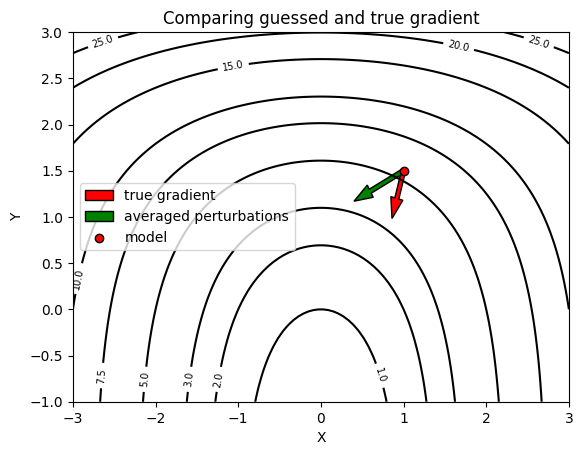

In [ ]:
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

Z = X**2 + math.e**Y

xpos = 1
ypos = 1.5

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)



plt.arrow(
    x=xpos,
    y=ypos,
    dx=-xpos * 2 * 0.07, #0.07 for scaling purposes only.
    dy=-math.e**2 * 0.07,
    facecolor="red",
    width=0.05,
    length_includes_head=True,
    label="true gradient",
)

plt.arrow(
    x=xpos,
    y=ypos,
    dx=-1.2 * 0.5,
    dy=-0.66 * 0.5,
    facecolor="green",
    width=0.05,
    length_includes_head=True,
    label="averaged perturbations",
)

plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")


plt.legend()
ax.set_title("Comparing guessed and true gradient")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

### 2nd order figures

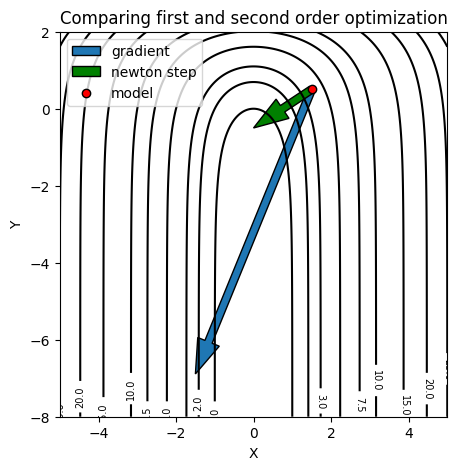

In [17]:
feature_x = np.linspace(-5, 5, 1000)
feature_y = np.linspace(-8, 2, 1000)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1, figsize=(5,5) )

Z = X**2 + math.e**Y

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
# plots filled contour plot

xpos = 1.5
ypos = 0.5
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


plt.arrow(
    x=xpos,
    y=ypos,
    dx=-xpos * 2,
    dy=-math.e**2,
    width=0.2,
    label="gradient",
    length_includes_head=True,
)

# Second order gradient
plt.arrow(x=xpos, y=ypos, dx=-xpos, dy=-1, width=0.2, facecolor="green", edgecolor="black", label="newton step",length_includes_head=True)


# learning rate of 0.1


plt.scatter(xpos, ypos, edgecolors="black", color="red", label="model")

plt.legend()
ax.set_title("Comparing first and second order optimization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

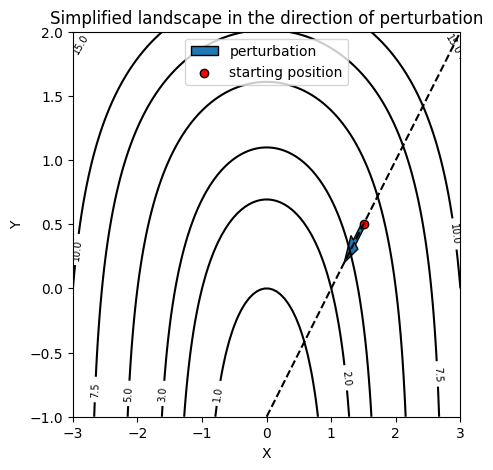

In [18]:
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 2, 100)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

Z = X**2 + math.e**Y

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]
# plots filled contour plot

xpos = 1.5
ypos = 0.5
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


plt.plot(
    [xpos - 1.5, xpos, xpos + 1.5],
    [ypos - 1.5, ypos, ypos + 1.5],
    "--",
    color="black",
)

plt.arrow(
    x=xpos,
    y=ypos,
    dx=-0.3,
    dy=-0.3,
    width=0.05,
    label="perturbation",
    length_includes_head=True,
)


# learning rate of 0.1


plt.scatter(xpos, ypos, edgecolors="black", color="red", label="starting position")

plt.legend()
ax.set_title("Simplified landscape in the direction of perturbation")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()



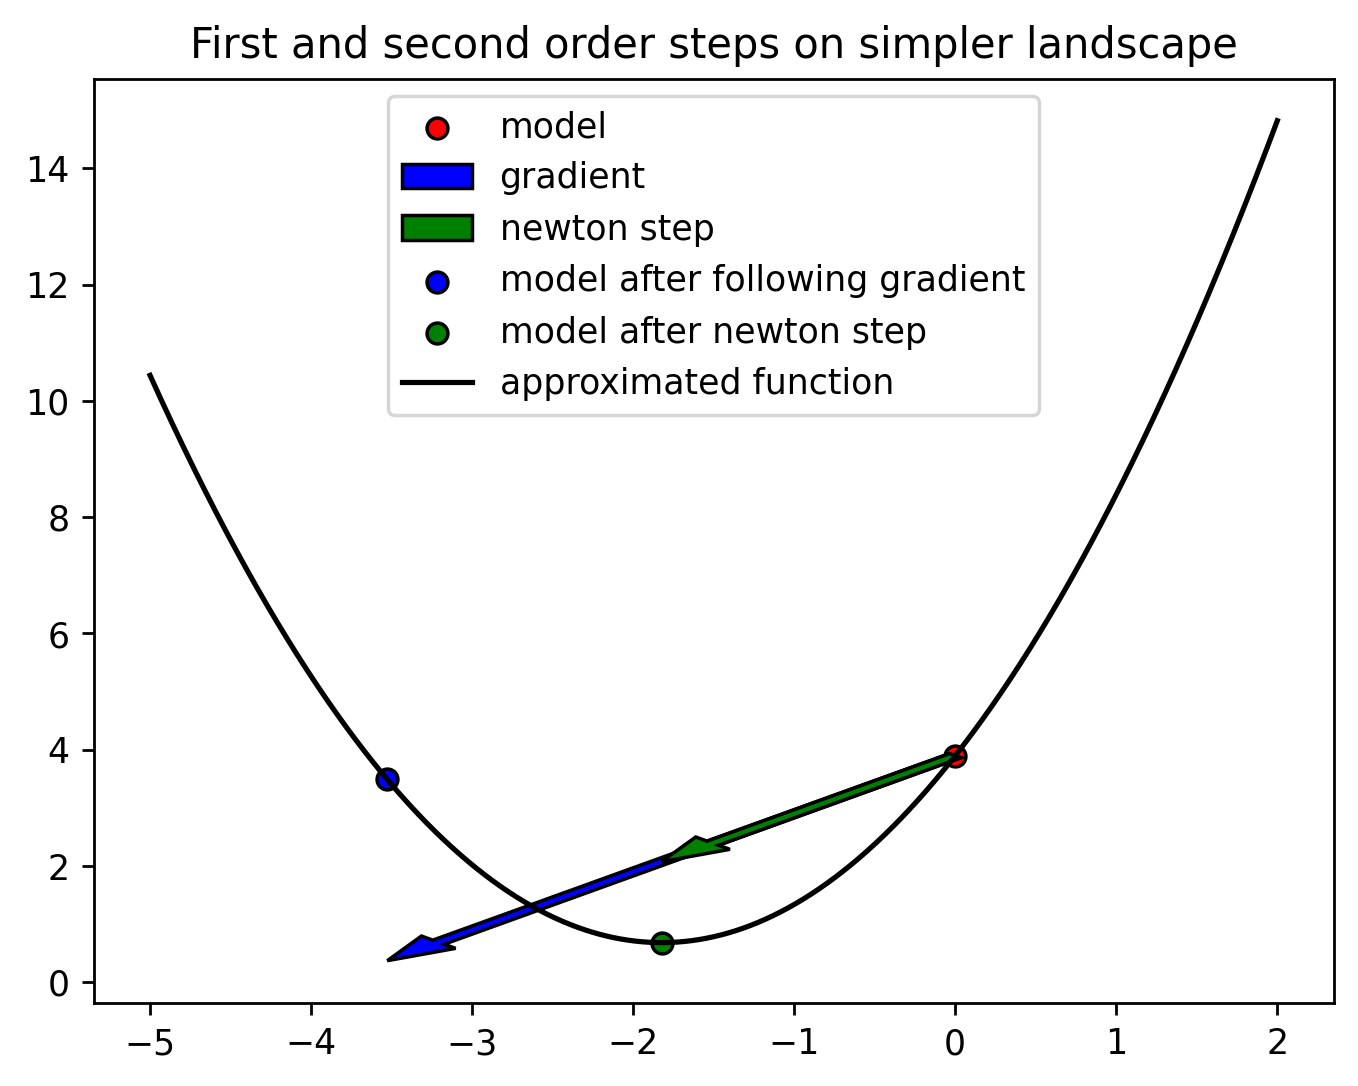

In [ ]:
# 0.967039x2−3.52685x+3.89872 - approximated function


def f(x):
    return 0.967039 * x**2 + 3.52685 * x + 3.89872

x = np.linspace(-5, 2, 4000)
y = f(x)


xpos = 0
ypos = f(xpos)
plt.scatter(xpos, ypos, facecolor="red", edgecolors="black", label="model" )


xpos2 = xpos - (1.934078 * xpos + 3.52685)
ypos2 = f(xpos2)
xpos3 = xpos - 1.82353038502
ypos3 = f(xpos3)

plt.arrow(
    x=xpos,
    y=ypos,
    dx=-(1.934078 * xpos + 3.52685),
    dy=-(1.934078 * xpos + 3.52685),
    width=0.1,
    facecolor="blue",
    label="gradient",
    length_includes_head=True,
)


plt.arrow(
    x=xpos,
    y=ypos,
    dx=-1.82353038502,
    dy=-1.82353038502,
    width=0.1,
    facecolor="green",
    label="newton step",
    length_includes_head=True,
)

plt.scatter(
    xpos2,
    ypos2,
    facecolor="blue",
    edgecolors="black",
    label="model after following gradient",
)
plt.title("First and second order steps on simpler landscape")
plt.scatter(
    xpos3, ypos3, facecolor="green", edgecolors="black", label="model after newton step"
)

plt.plot(x, y, label="approximated function", color="black")

plt.legend()


plt.show()
# dx 1.934078x+3.52685

# dx^2 1.934078
# newton step at 0 = 3.52685/1.934078

### Meta figure

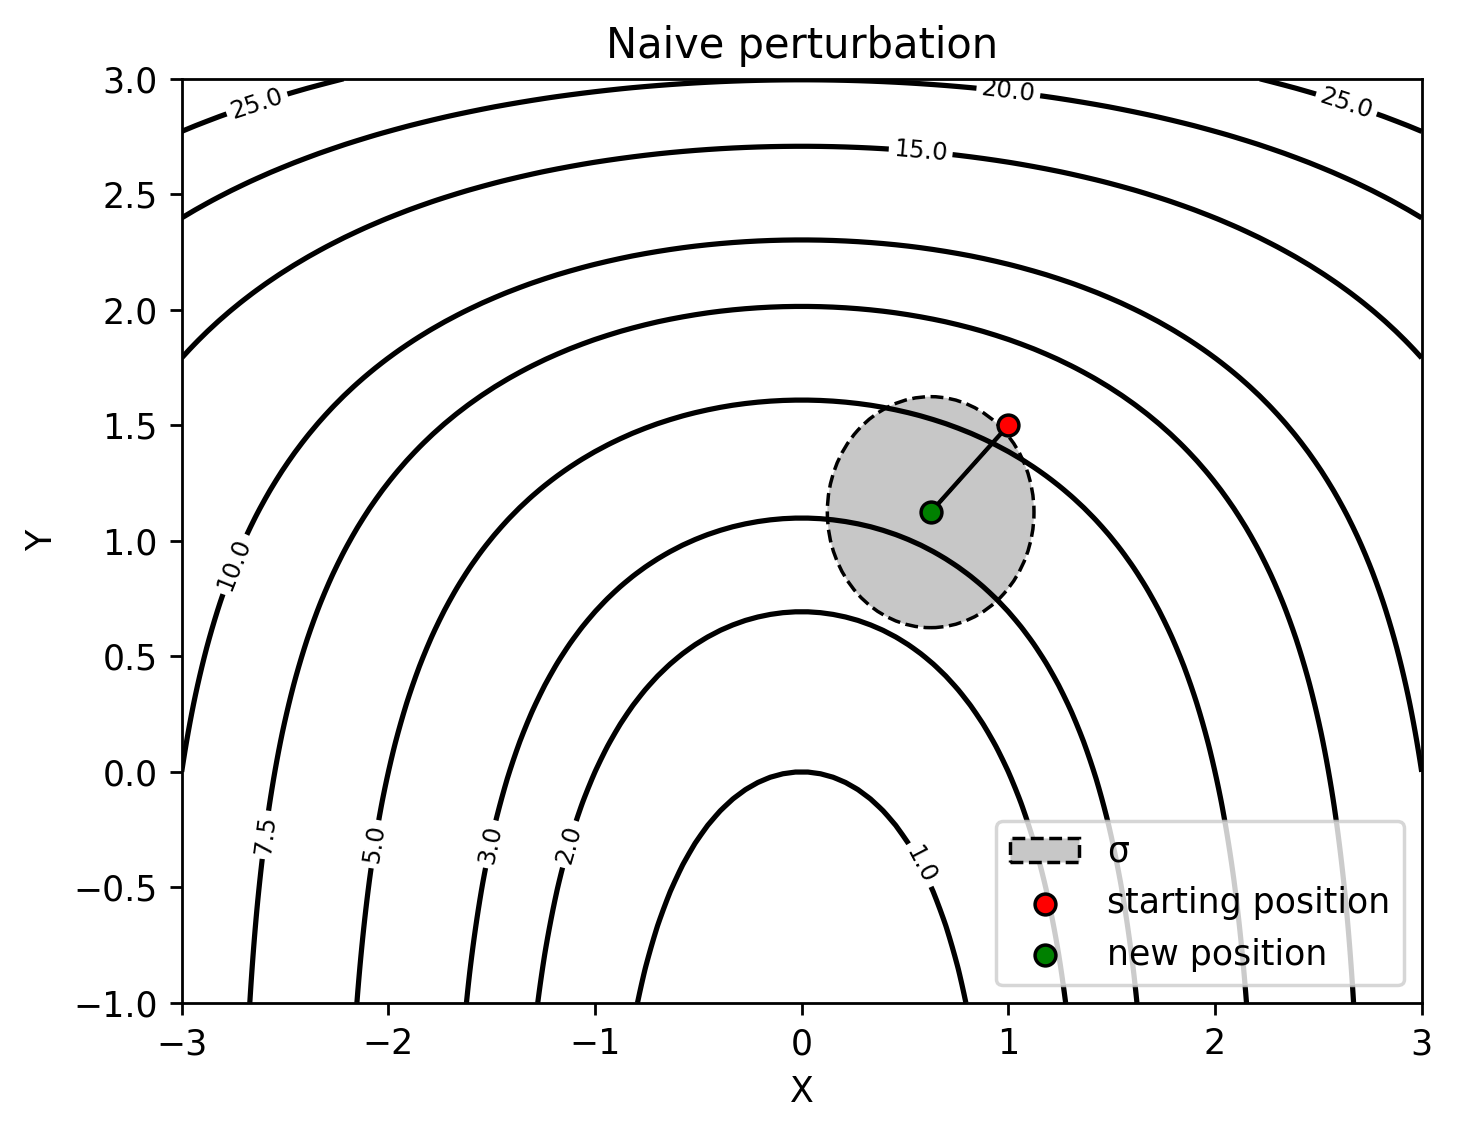

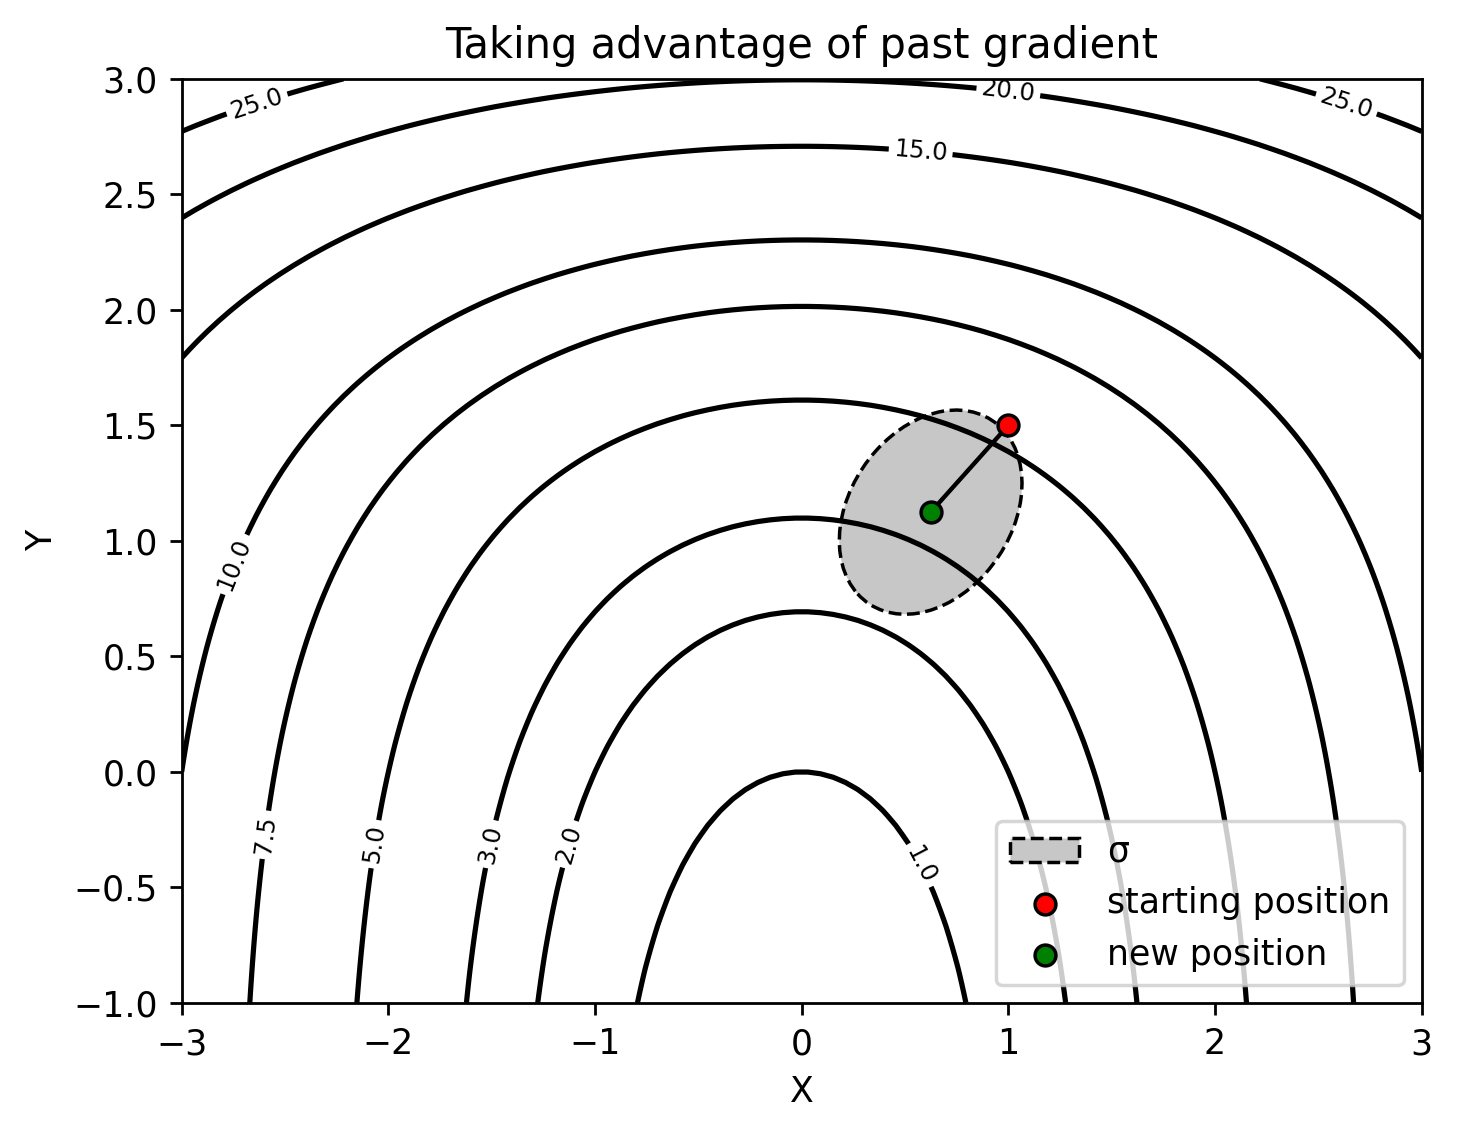

In [8]:
feature_x = np.linspace(-3, 3, 100)
feature_y = np.linspace(-1, 3, 100)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)

xpos = 1
ypos = 1.5
Z = X**2 + math.e**Y

labels = [0, 1, 2, 3, 5, 7.5, 10, 15, 20, 25, 30]


# Figure 1

CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)


circ = plt.Circle(
    (
        xpos - 0.376,
        ypos - 0.376,
    ),
    radius=0.5,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)

plt.arrow(x=xpos, y=ypos, dx=-0.376, dy=-0.376, width=0.004, head_width=0.02)
# plt.arrow(x=xpos, y=ypos, dx=0.3, dy=0.3, width=0.004, head_width=0.02)

# original point [1, 1.5] -> loss = 5.4816
# new point [0.7, 1.2] -> loss = 3.81
# other point [1.3, 1.8] -> loss = 7.73965

# Update rule is -lr * n/size_pert^2 * (loss_dif * perturbation)
# -0.05 * 2/((0.3)^2+(0.3)^2) * (5.4816-7.73965) * 0.3 = -0.376


plt.scatter(xpos, ypos, edgecolors="black", color="red", label="starting position")
plt.scatter(
    xpos - 0.376, ypos - 0.376, edgecolors="black", color="green", label="new position"
)

plt.legend()
ax.set_title("Naive perturbation")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

# Figure 2
[X, Y] = np.meshgrid(feature_x, feature_y)

fig, ax = plt.subplots(1, 1)
CS = ax.contour(X, Y, Z, levels=labels, colors="black")
ax.clabel(CS, fontsize=7)

from matplotlib.patches import Ellipse

circ = Ellipse(
    (
        xpos - 0.376,
        ypos - 0.376,
    ),
    width=0.75,
    height=1,
    angle=-45,
    facecolor="#c7c7c7",
    linewidth=1,
    edgecolor="black",
    linestyle="--",
    label="\u03C3",
)
ax.add_patch(circ)

plt.arrow(x=xpos, y=ypos, dx=-0.376, dy=-0.376, width=0.004, head_width=0.02)
# plt.arrow(x=xpos, y=ypos, dx=0.3, dy=0.3, width=0.004, head_width=0.02)

# original point [1, 1.5] -> loss = 5.4816
# new point [0.7, 1.2] -> loss = 3.81
# other point [1.3, 1.8] -> loss = 7.73965

# Update rule is -lr * n/size_pert^2 * (loss_dif * perturbation)
# -0.05 * 2/((0.3)^2+(0.3)^2) * (5.4816-7.73965) * 0.3 = -0.376


plt.scatter(xpos, ypos, edgecolors="black", color="red", label="starting position")
plt.scatter(
    xpos - 0.376, ypos - 0.376, edgecolors="black", color="green", label="new position"
)

plt.legend()
ax.set_title("Taking advantage of past gradient")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

## Results figures

### Sweep loading

### Code

In [3]:
def Nr_forward_passes(run, algorithm):
    num_perts = run.config.get("num_perts")
    if "forw" in algorithm.lower() or "ffd" in algorithm.lower():
        Num_passes = int(num_perts + 1)
    elif "cent" in algorithm.lower() or "cfd" in algorithm.lower():
        Num_passes = int(num_perts * 2)
    return Num_passes


def get_metrics(sweep, epochs=499, do_angle=True):
    sweep_runs = sweep.runs
    algorithm = []
    Num_passes = np.zeros((len(sweep_runs)))
    loss = np.zeros((len(sweep_runs), epochs))
    acc = np.zeros((len(sweep_runs), epochs))
    angle = np.zeros((len(sweep_runs), epochs))
    ose = np.zeros((len(sweep_runs), epochs))

    for i, run in enumerate(sweep_runs):

        history = run.history(pandas=False)
        algorithm.append(run.config.get("algorithm"))
        Num_passes[i] = (
            Nr_forward_passes(run, algorithm[i])
            if (algorithm[i].lower() != "bp")
            else 1
        )
        # .history apparently does not return things in chronological order https://github.com/wandb/wandb/issues/5219
        for n, epoch in enumerate(history[:epochs]):
            if run.config.get("validation"):
                loss[i, n] = epoch["validation/loss"]
                acc[i, n] = epoch["validation/acc"]
            else:
                loss[i, n] = epoch["test/loss"]
                acc[i, n] = epoch["test/acc"]

            if algorithm[i].lower() != "bp" and do_angle:
                ose[i, n] = epoch["angle/OSE"]
                angle[i, n] = epoch["angle/angle"]
    #forward_flops, backward_flops, total_flops = flops.FLOP_step_track()
    metric_names = ["loss", "accuracy", "angle", "OSE", "number of passes"]
        
    return metric_names, [loss, acc, angle, ose, Num_passes, algorithm]

In [6]:
Flops_1 = {}
Flops_2 = {}

model_bp = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3072, 10))

model_wp = torch.nn.Sequential(
    torch.nn.Flatten(),
    WPLinear(
        3072,
        10,
        bias=True,
        pert_type="ffd",
        dist_sampler=utils.make_dist_sampler("normal", "cuda:0"),
        sigma="0",
        num_perts=1,
        device="cuda:0",
        zero_masking=False,
    ),
)
algorithms = ["FFD", "CFD"]
perturbations_1 = np.arange(1, 33, 1)
perturbations_2 = np.array([1, 32, 512, 1024])

for algorithm in algorithms:
    for perturbation in perturbations_1:

        Flops_1[(algorithm, perturbation)] = fl.FLOP_abstract_track(
            algorithm=algorithm, num_perts=perturbation, network=model_wp
        )
    for perturbation in perturbations_2:
        Flops_2[(algorithm, perturbation)] = fl.FLOP_abstract_track(
            algorithm=algorithm, num_perts=perturbation, network=model_wp
        )

Flops_1[("BP", 0)] = fl.FLOP_abstract_track(
            algorithm="BP", num_perts=0, network=model_bp
        )
Flops_2[("BP", 0)]= fl.FLOP_abstract_track(
            algorithm="BP", num_perts=0, network=model_bp
        )

Flops_FFD_63 = fl.FLOP_abstract_track(algorithm="FFD", num_perts=63, network=model_wp)

this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linear layer
this is WP linea

### One layer, 1 to 32 perturbations experiment (on validation set, 100 epochs!)

In [7]:
# Relevant Sweeps

api = wandb.Api()
Meta_FFD_CIFAR10 = api.sweep("brai-lab/MetaWP/4sjhorfq")
Meta_CFD_CIFAR10 = api.sweep("brai-lab/MetaWP/z6sw9uuq")

grad_estimation = api.sweep("brai-lab/MetaWP/exxsjl9q")


CFD_CIFAR10_increasing_perts = api.sweep("brai-lab/MetaWP/klkcsplp")
CFD_CIFAR10_increasing_perts2 = api.sweep("brai-lab/MetaWP/p7wzm3eh")
FFD_CIFAR10_increasing_perts = api.sweep("brai-lab/MetaWP/qoemz20p")
FFD_CIFAR10_63perts = api.sweep("brai-lab/MetaWP/ajdxj22b")

In [8]:
# _, grad_estimation_stats = get_metrics(grad_estimation,99)


_, CFD_CIFAR10_increasing_perts_stats = get_metrics(CFD_CIFAR10_increasing_perts,99)
_, CFD_CIFAR10_increasing_perts2_stats = get_metrics(CFD_CIFAR10_increasing_perts2,99)
_, FFD_CIFAR10_increasing_perts_stats = get_metrics(FFD_CIFAR10_increasing_perts,99)
_, FFD_CIFAR10_increasing_perts2_stats = get_metrics(FFD_CIFAR10_63perts, 99)

BP_Cifar10_validation = api.sweep("brai-lab/MetaWP/im6s82i0")  # find BP validation run!

_, BP_CIFAR10_stats = get_metrics(BP_Cifar10_validation, 99)


CFD_CIFAR10_increasing_perts_combined_stats = CFD_CIFAR10_increasing_perts_stats
FFD_CIFAR10_increasing_perts_combined_stats = FFD_CIFAR10_increasing_perts_stats

for stat in range(len(CFD_CIFAR10_increasing_perts_combined_stats) - 1):

    CFD_CIFAR10_increasing_perts_combined_stats[stat] = np.append(
        CFD_CIFAR10_increasing_perts_stats[stat],
        CFD_CIFAR10_increasing_perts2_stats[stat],
        axis=0,
    )
    FFD_CIFAR10_increasing_perts_combined_stats = np.append(
        FFD_CIFAR10_increasing_perts_stats[stat],
        FFD_CIFAR10_increasing_perts2_stats[stat],
        axis=0,
    )

In [12]:
print(FFD_CIFAR10_increasing_perts_combined_stats)

[33. 33. 33. 33. 33. 32. 32. 32. 32. 32. 31. 31. 31. 31. 31. 30. 30. 30.
 30. 30. 29. 29. 29. 29. 29. 28. 28. 28. 28. 28. 27. 27. 27. 27. 27. 26.
 26. 26. 26. 26. 25. 25. 25. 25. 25. 24. 24. 24. 24. 24. 23. 23. 23. 23.
 23. 22. 22. 22. 22. 22. 21. 21. 21. 21. 21. 20. 20. 20. 20. 20. 19. 19.
 19. 19. 19. 18. 18. 18. 18. 18. 17. 17. 17. 17. 17. 16. 16. 16. 16. 16.
 15. 15. 15. 15. 15. 14. 14. 14. 14. 14. 13. 13. 13. 13. 13. 12. 12. 12.
 12. 12. 11. 11. 11. 11. 11. 10. 10. 10. 10. 10.  9.  9.  9.  9.  9.  8.
  8.  8.  8.  8.  7.  7.  7.  7.  7.  6.  6.  6.  6.  6.  5.  5.  5.  5.
  5.  4.  4.  4.  4.  4.  3.  3.  3.  3.  3.  2.  2.  2.  2.  2. 64. 64.
 64. 64. 64.]


In [51]:
print(np.argmin(BP_CIFAR10_stats[0][:, -1]))
print(BP_CIFAR10_stats[0][8, -1])

8
1.8665254152297974


##### Flops cost of increasing perturbations plot

In [57]:
print(Flops_vals_list[-1][2])
print(np.flip(Flops_vals_list[:32][:, 2]))

122900
[4977610 4823980 4670350 4516720 4363090 4209460 4055830 3902200 3748570
 3594940 3441310 3287680 3134050 2980420 2826790 2673160 2519530 2365900
 2212270 2058640 1905010 1751380 1597750 1444120 1290490 1136860  983230
  829600  675970  522340  368710  184350]


(32,)
()


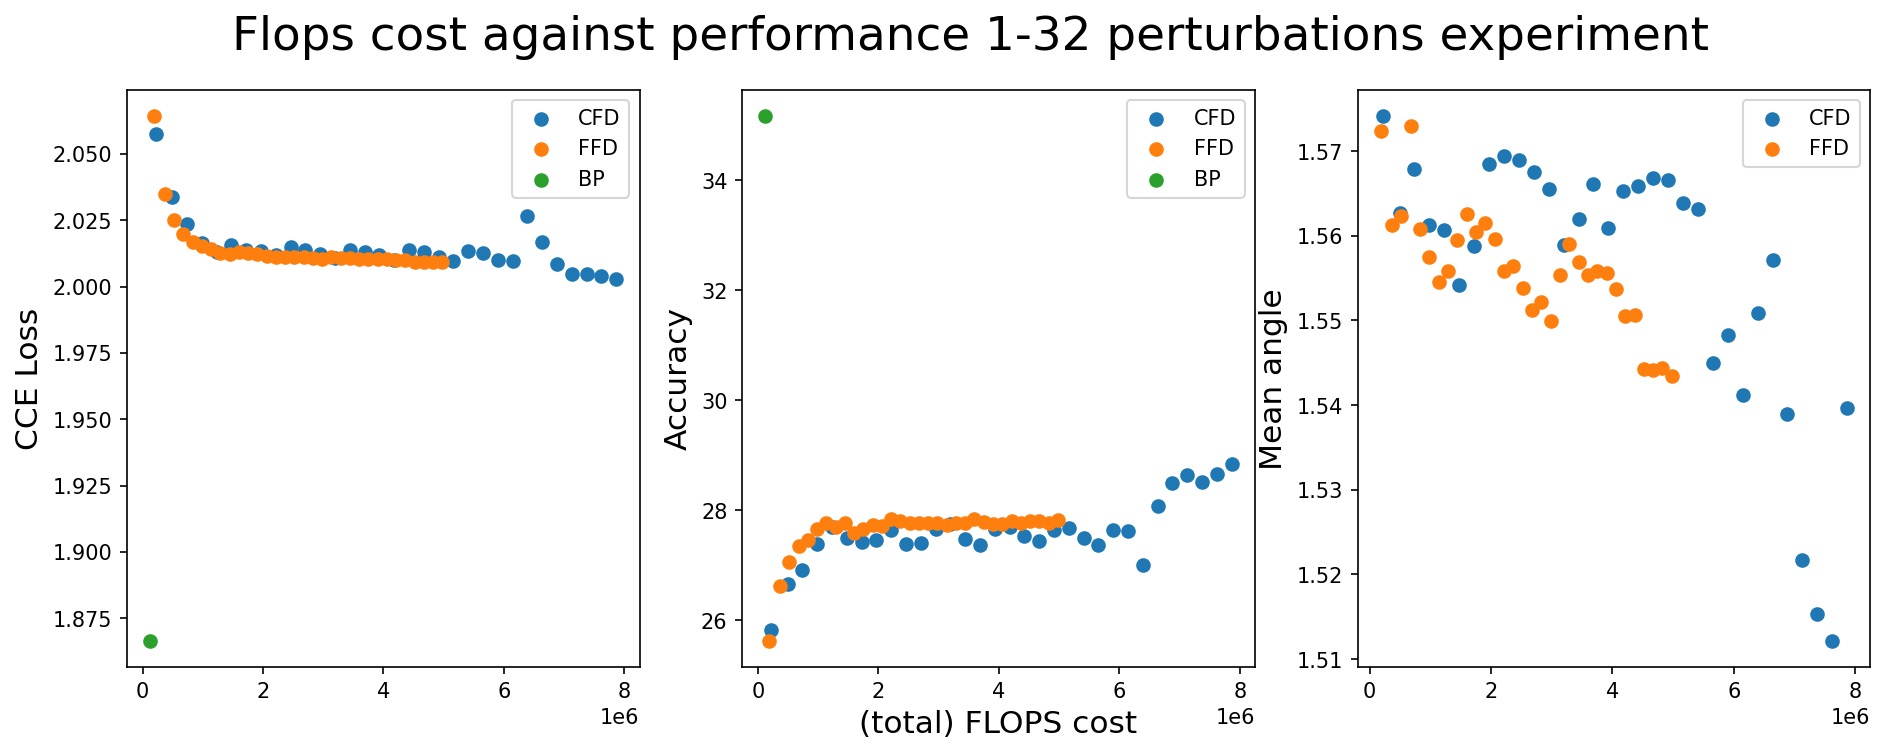

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
# loss, acc, angle, ose, Num_passes, algorithm
f.set_dpi(150)

Flops_vals_list = np.array(list(Flops_1.values()))

Flops_FFD = np.flip(Flops_vals_list[:32][:, 2]) #only the total count included here. First slice selects the FFD values, second selects the total FLOPS
Flops_CFD = np.flip(Flops_vals_list[32:-1][:, 2])
Flops_BP = Flops_vals_list[-1][2]


x = 15
plt.suptitle("Flops cost against performance 1-32 perturbations experiment", fontsize=x * 1.5)

axs[0].set_ylabel("CCE Loss", fontsize=x)
axs[0].scatter(
    Flops_CFD,
    CFD_CIFAR10_increasing_perts_combined_stats[0][:, -1]
    .reshape((32, -1))
    .mean(axis=1),
    label="CFD",
)
axs[0].scatter(
    [Flops_FFD, ,
    FFD_CIFAR10_increasing_perts_stats[0][:, -1].reshape((32, -1)).mean(axis=1),
    label="FFD",
)


axs[0].scatter(
    Flops_BP,
    BP_CIFAR10_stats[0][8, -1].mean(),
    label="BP",
)

axs[0].legend(loc="upper right")

axs[1].scatter(
    Flops_CFD,
    CFD_CIFAR10_increasing_perts_combined_stats[1][:, -1]
    .reshape((32, -1))
    .mean(axis=1),
    label="CFD",
)

axs[1].scatter(
    Flops_FFD,
    FFD_CIFAR10_increasing_perts_stats[1][:, -1].reshape((32, -1)).mean(axis=1),
    label="FFD",
)

axs[1].scatter(
    Flops_BP,
    BP_CIFAR10_stats[1][8, -1].mean(),
    label="BP",
)

axs[1].set_xlabel("(total) FLOPS cost", fontsize=x)
axs[1].set_ylabel("Accuracy", fontsize=x)
axs[1].legend(loc="upper right")

axs[2].scatter(
    Flops_CFD,
    CFD_CIFAR10_increasing_perts_combined_stats[2]
    .mean(axis=1)
    .reshape((32, -1))
    .mean(axis=1),
    label="CFD",
)

axs[2].scatter(
    Flops_FFD,
    FFD_CIFAR10_increasing_perts_stats[2].mean(axis=1).reshape((32, -1)).mean(axis=1),
    label="FFD",
)



axs[2].set_ylabel("Mean angle", fontsize=x)

axs[2].legend(loc="upper right")


plt.show()

##### Num of forward passes plot

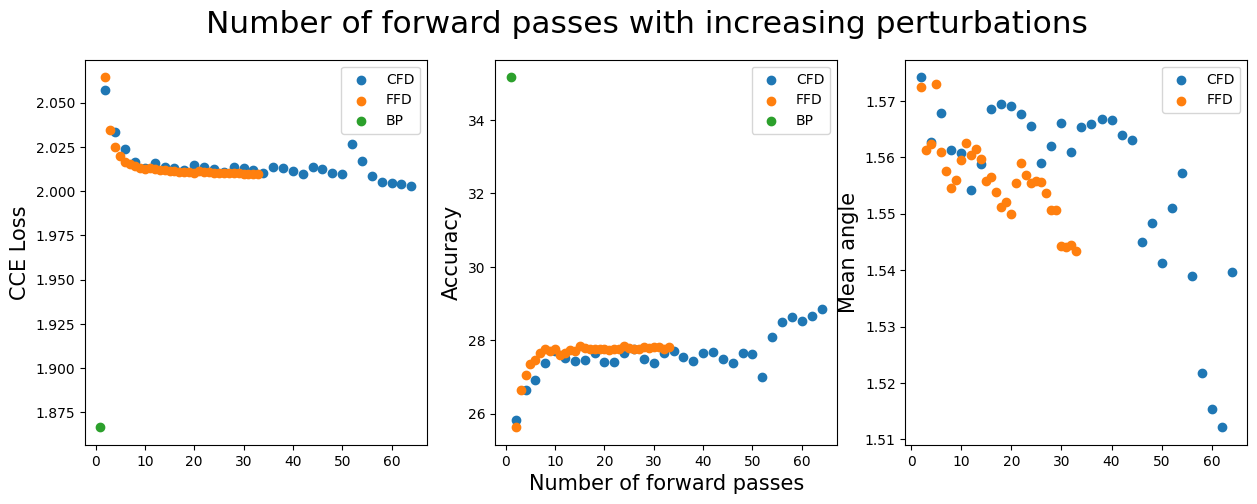

In [56]:
x = 15
f, axs = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle("Number of forward passes with increasing perturbations", fontsize=x * 1.5)

axs[0].set_ylabel("CCE Loss", fontsize=x)
axs[0].scatter(
    np.flip(np.unique(CFD_CIFAR10_increasing_perts_combined_stats[4])),
    CFD_CIFAR10_increasing_perts_combined_stats[0][:, -1]
    .reshape((32, -1))
    .mean(axis=1),
    label="CFD",
)
axs[0].scatter(
    np.flip(np.unique(FFD_CIFAR10_increasing_perts_stats[4])),
    FFD_CIFAR10_increasing_perts_stats[0][:, -1].reshape((32, -1)).mean(axis=1),
    label="FFD",
)
axs[0].scatter(
    np.flip(np.unique(BP_CIFAR10_stats[4])),
    BP_CIFAR10_stats[0][8, -1],
    label="BP",
)
axs[0].legend(loc="upper right")

axs[1].scatter(
    np.flip(np.unique(CFD_CIFAR10_increasing_perts_combined_stats[4])),
    CFD_CIFAR10_increasing_perts_combined_stats[1][:, -1]
    .reshape((32, -1))
    .mean(axis=1),
    label="CFD",
)

axs[1].scatter(
    np.flip(np.unique(FFD_CIFAR10_increasing_perts_stats[4])),
    FFD_CIFAR10_increasing_perts_stats[1][:, -1].reshape((32, -1)).mean(axis=1),
    label="FFD",
)

axs[1].scatter(
    np.flip(np.unique(BP_CIFAR10_stats[4])),
    BP_CIFAR10_stats[1][8, -1],
    label="BP",
)

axs[1].set_xlabel("Number of forward passes", fontsize=x)
axs[1].set_ylabel("Accuracy", fontsize=x)
axs[1].legend(loc="upper right")

axs[2].scatter(
    np.flip(np.unique(CFD_CIFAR10_increasing_perts_combined_stats[4])),
    CFD_CIFAR10_increasing_perts_combined_stats[2]
    .mean(axis=1)
    .reshape((32, -1))
    .mean(axis=1),
    label="CFD",
)

axs[2].scatter(
    np.flip(np.unique(FFD_CIFAR10_increasing_perts_stats[4])),
    FFD_CIFAR10_increasing_perts_stats[2].mean(axis=1).reshape((32, -1)).mean(axis=1),
    label="FFD",
)


axs[2].set_ylabel("Mean angle", fontsize=x)

axs[2].legend(loc="upper right")


plt.show()

### Meta experiment

In [ ]:
_, Meta_FFD_CIFAR10_stats = get_metrics(Meta_FFD_CIFAR10)
_, Meta_CFD_CIFAR10_stats = get_metrics(Meta_CFD_CIFAR10)
_, grad_estimation_stats = get_metrics(grad_estimation)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

### One layer 1,2, 32, 512, 1024 perturbations experiment (best lr for each perturbation), test set, 500 epochs

#### loading datasets

In [63]:
api = wandb.Api()

In [64]:
FFD_Mnist_best1 = api.sweep("brai-lab/MetaWP/pqgsrv6j")
BP_Mnist = api.sweep("brai-lab/MetaWP/yeudfda9")
CFD_Mnist_best1 = api.sweep("brai-lab/MetaWP/qzfa1v1l")

_, FFD_MNIST_stats = get_metrics(FFD_Mnist_best1)
_, CFD_MNIST_stats = get_metrics(CFD_Mnist_best1)
_, BP_MNIST_stats = get_metrics(BP_Mnist)

In [ ]:
BP_Cifar10 = api.sweep("brai-lab/MetaWP/rdlxynh1")


FFD_Cifar10_best1 = api.sweep("brai-lab/MetaWP/0jmmy50t")
CFD_Cifar10_best1 = api.sweep(
    "brai-lab/MetaWP/hc97lew4"
)  # sweep with 1, 32, 512 perturbations trained with learning rate best for 1 perturbation


CFD_CIFAR10_1024_best1024 = api.sweep("brai-lab/MetaWP/n40d7zev") #1024 perturbations trained with learning rate tuned for 1024 perturbations
FFD_CIFAR10_1024_best1024 = api.sweep("brai-lab/MetaWP/uts0dwrh")

CFD_CIFAR10_512_best512 = api.sweep("brai-lab/MetaWP/3bphynjr")
FFD_CIFAR10_512_best512 = api.sweep("brai-lab/MetaWP/3cr12lcv")

CFD_CIFAR10_32_best32 = api.sweep("brai-lab/MetaWP/2nxtwwpb")
FFD_CIFAR10_32_best32 = api.sweep("brai-lab/MetaWP/4lac4jyg") 

In [67]:
metric_names, FFD_CIFAR10_stats = get_metrics(FFD_Cifar10_best1)
_, CFD_CIFAR10_stats = get_metrics(CFD_Cifar10_best1)
_, BP_CIFAR10_test_stats = get_metrics(BP_Cifar10)



In [ ]:
_, CFD_cifar10_1024 = get_metrics(CFD_CIFAR10_1024_best1024)
_, FFD_cifar10_1024 = get_metrics(FFD_CIFAR10_1024_best1024)


_, CFD_cifar10_512 = get_metrics(CFD_CIFAR10_512_best512)
_, FFD_cifar10_512 = get_metrics(FFD_CIFAR10_512_best512)
_, CFD_cifar10_32 = get_metrics(CFD_CIFAR10_32_best32)
_, FFD_cifar10_32 = get_metrics(FFD_CIFAR10_32_best32)

In [ ]:
CFD_stats = CFD_CIFAR10_stats.copy()
FFD_stats = FFD_CIFAR10_stats.copy()


for stat in range(len(CFD_stats) - 1):
    CFD_stats[stat] = CFD_stats[stat][-5:] #cut down to only the 1 perturbation case
    FFD_stats[stat] = FFD_stats[stat][-5:]  # cut down to only the 1 perturbation case

    print(stat)
    CFD_stats[stat] = np.append(
        CFD_stats[stat],
        CFD_cifar10_32[stat],
        axis=0,
    )
    CFD_stats[stat] = np.append(
        CFD_stats[stat],
        CFD_cifar10_512[stat],
        axis=0,
    )

    CFD_stats[stat] = np.append(
        CFD_stats[stat],
        CFD_cifar10_1024[stat],
        axis=0,
    )

    FFD_stats[stat] = np.append(
        FFD_stats[stat],
        FFD_cifar10_32[stat],
        axis=0,
    )

    FFD_stats[stat] = np.append(
        FFD_stats[stat],
        FFD_cifar10_512[stat],
        axis=0,
    )
    FFD_stats[stat] = np.append(
        FFD_stats[stat],
        FFD_cifar10_1024[stat],
        axis=0,
    )


0
1
2
3
4


In [ ]:
def make_boxplots(FFD_stats, CFD_stats, BP_stats, num_groups, name):

    cfd_acc = np.split(CFD_stats[1][:, -1], num_groups) #Split into groups, and take only the last epoch for each metric
    cfd_loss = np.split(CFD_stats[0][:, -1], num_groups)
    ffd_acc = np.split(FFD_stats[1][:, -1], num_groups)
    ffd_loss = np.split(FFD_stats[0][:, -1], num_groups)
    accs = [BP_stats[1][:, -1]]
    losses = [BP_stats[0][:, -1]]
    labels = ["(BP) " + str(1)]

    print(np.unique(CFD_stats[4]))
    CFD_num_passes = np.unique(CFD_stats[4])
    FFD_num_passes = np.unique(FFD_stats[4])

    for i in range(num_groups):
        labels.append("(FFD) " + str(int(FFD_num_passes[i])))

        labels.append("(CFD) " + str(int(CFD_num_passes[i])))
        accs.append(ffd_acc[i])
        accs.append(cfd_acc[i])
        losses.append(ffd_loss[i])
        losses.append(cfd_loss[i])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.set_dpi(400)
    ax1.set_title(f"Accuracy vs number of forward passes on {name}")
    ax1.set_ylabel("Accuracy (test set)")

    ax1.set_xlabel("Nr. forward passes")
    ax1.boxplot(accs, tick_labels=labels)

    ax2.set_title(f"Loss vs number of forward passes on {name}")
    ax2.set_ylabel("Loss (test set)")

    ax2.set_xlabel("Nr. forward passes")
    ax2.boxplot(losses, tick_labels=labels)

    plt.show()

#### plotting

[2.000e+00 6.400e+01 1.024e+03 2.048e+03]


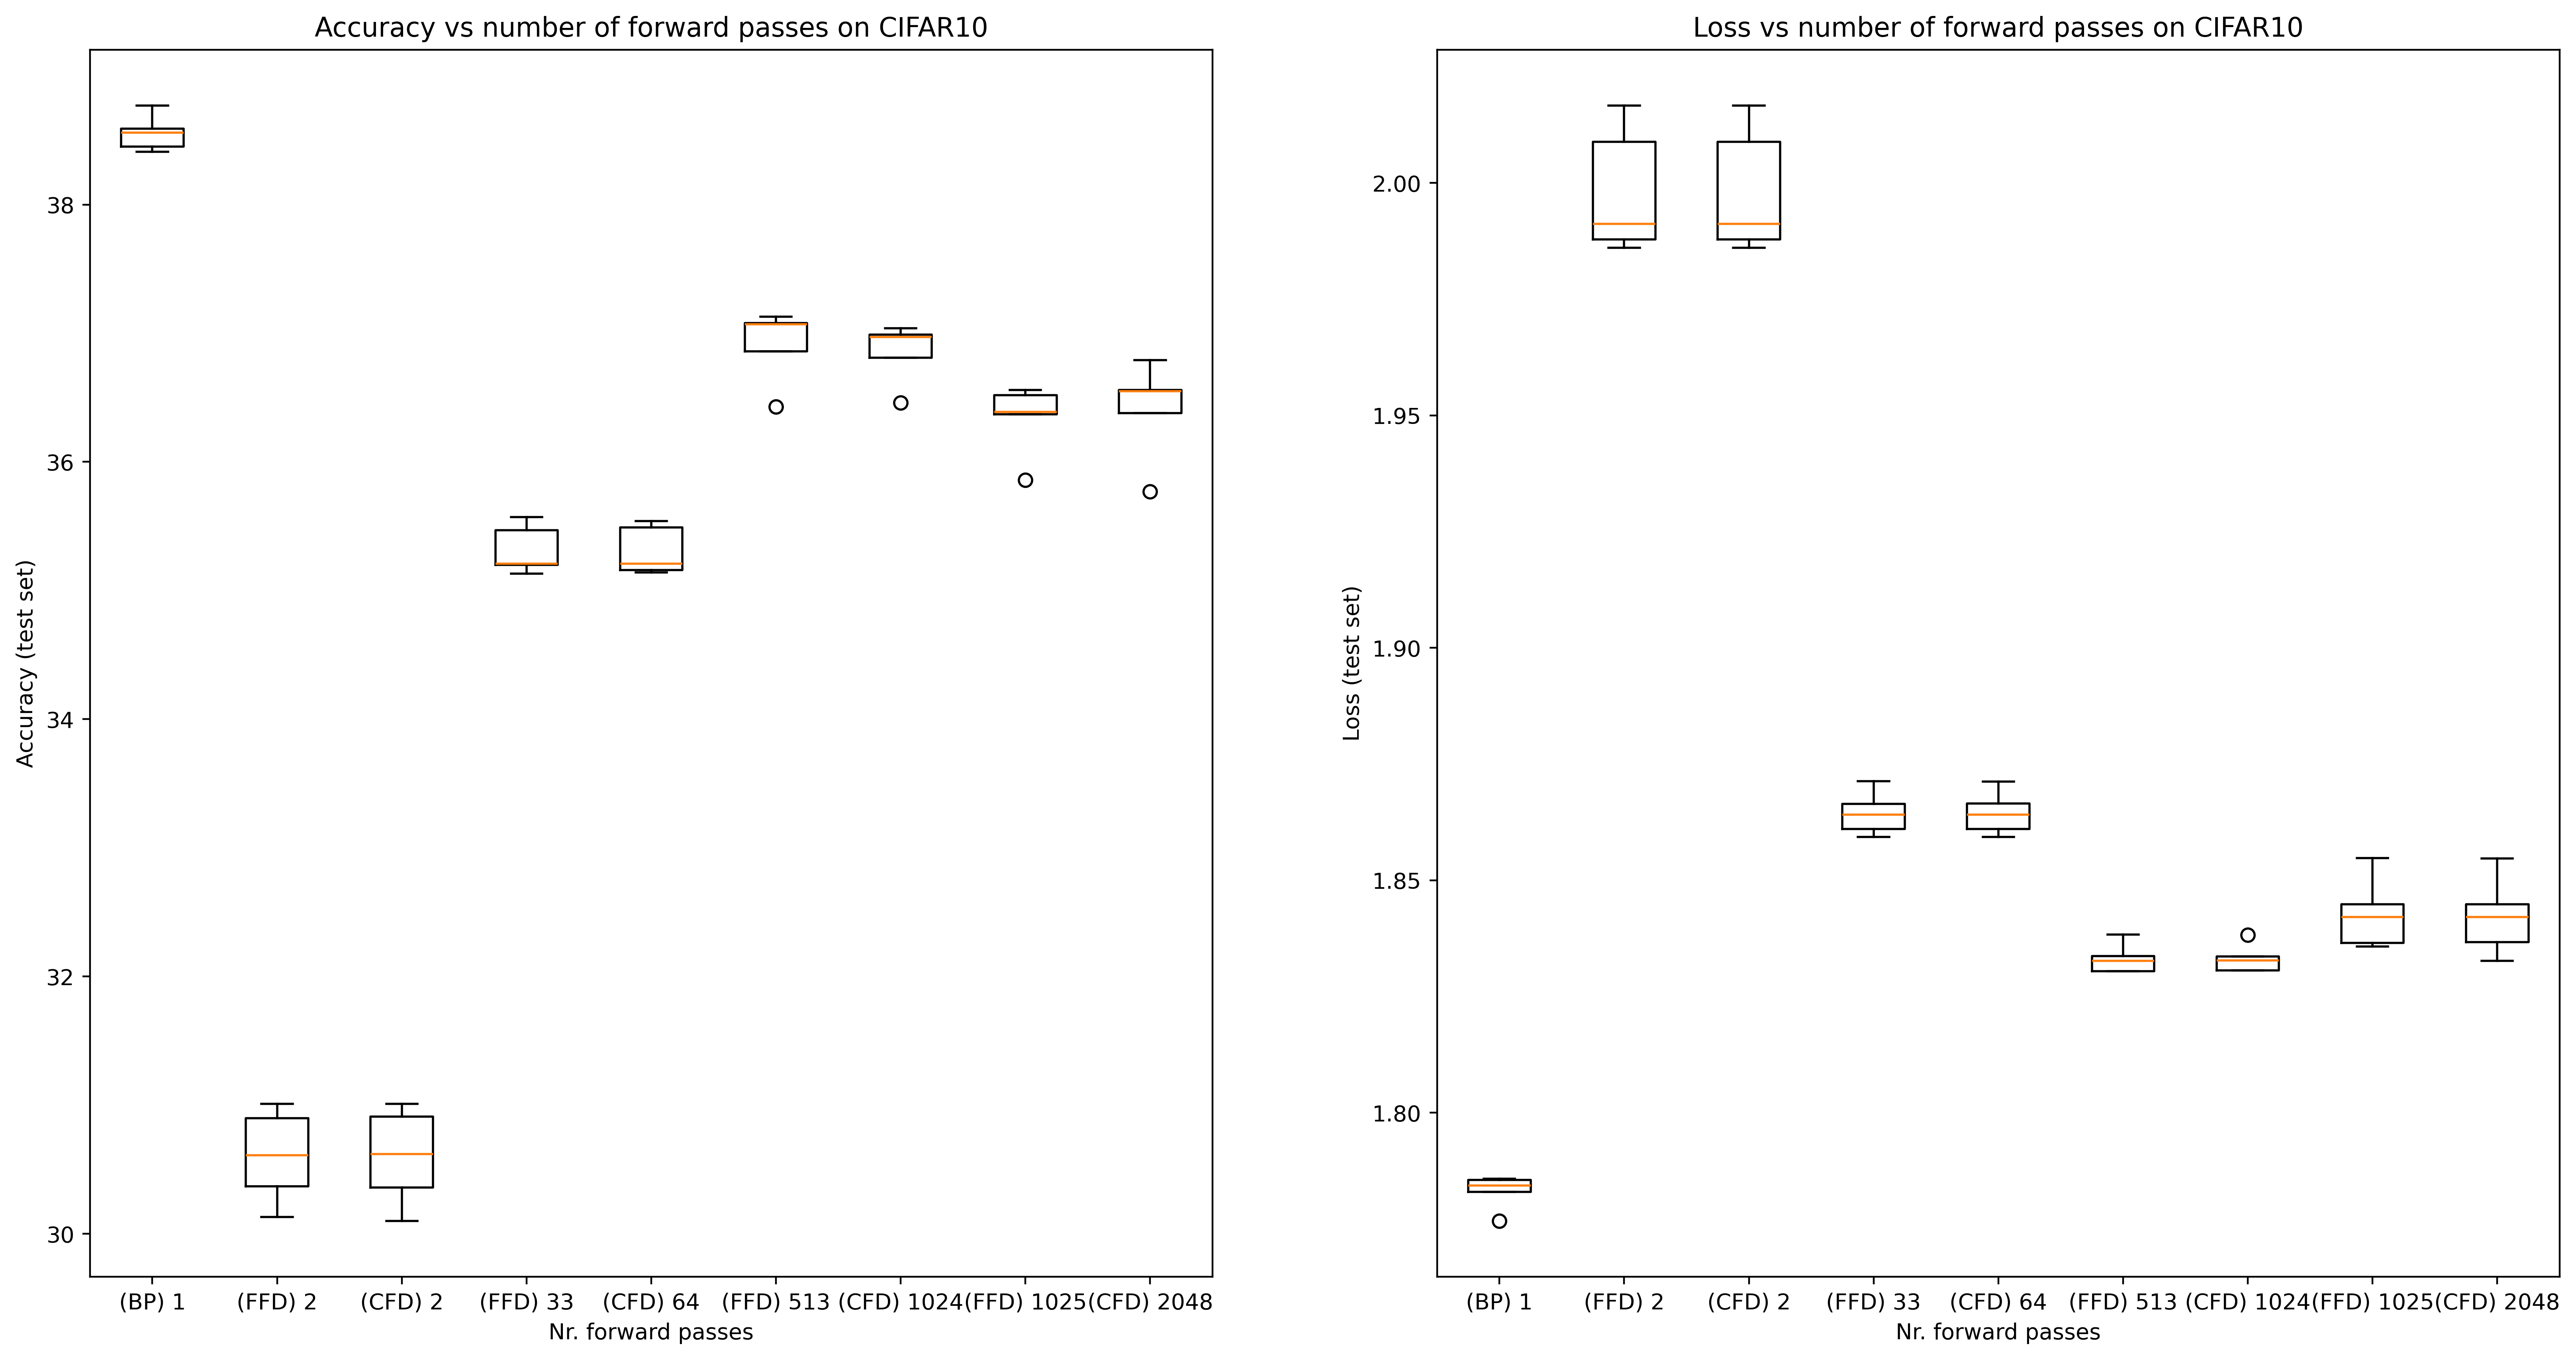

In [ ]:
make_boxplots(FFD_stats, CFD_stats, BP_CIFAR10_test_stats, 4, "CIFAR10")

In [19]:
print(Flops_2)
Flops_vals_list = np.array(list(Flops_2.values()))
print(Flops_vals_list[:4][:, 2])
print(CFD_stats[4])

{('FFD', np.int64(1)): [tensor(153620), tensor(30730), tensor(184350)], ('FFD', np.int64(32)): [tensor(3010890), tensor(1966720), tensor(4977610)], ('FFD', np.int64(512)): [tensor(47252490), tensor(31467520), tensor(78720010)], ('FFD', np.int64(1024)): [tensor(94443530), tensor(62935040), tensor(157378570)], ('CFD', np.int64(1)): [tensor(184350), tensor(30730), tensor(215080)], ('CFD', np.int64(32)): [tensor(5898890), tensor(1966720), tensor(7865610)], ('CFD', np.int64(512)): [tensor(94382090), tensor(31467520), tensor(125849610)], ('CFD', np.int64(1024)): [tensor(188764170), tensor(62935040), tensor(251699210)], ('BP', 0): [tensor(61450), tensor(61450), tensor(122900)]}
[   184350   4977610  78720010 157378570]
[2.000e+00 2.000e+00 2.000e+00 2.000e+00 2.000e+00 6.400e+01 6.400e+01
 6.400e+01 6.400e+01 6.400e+01 1.024e+03 1.024e+03 1.024e+03 1.024e+03
 1.024e+03 2.048e+03 2.048e+03 2.048e+03 2.048e+03 2.048e+03]


##### Plot FLOPS total cost

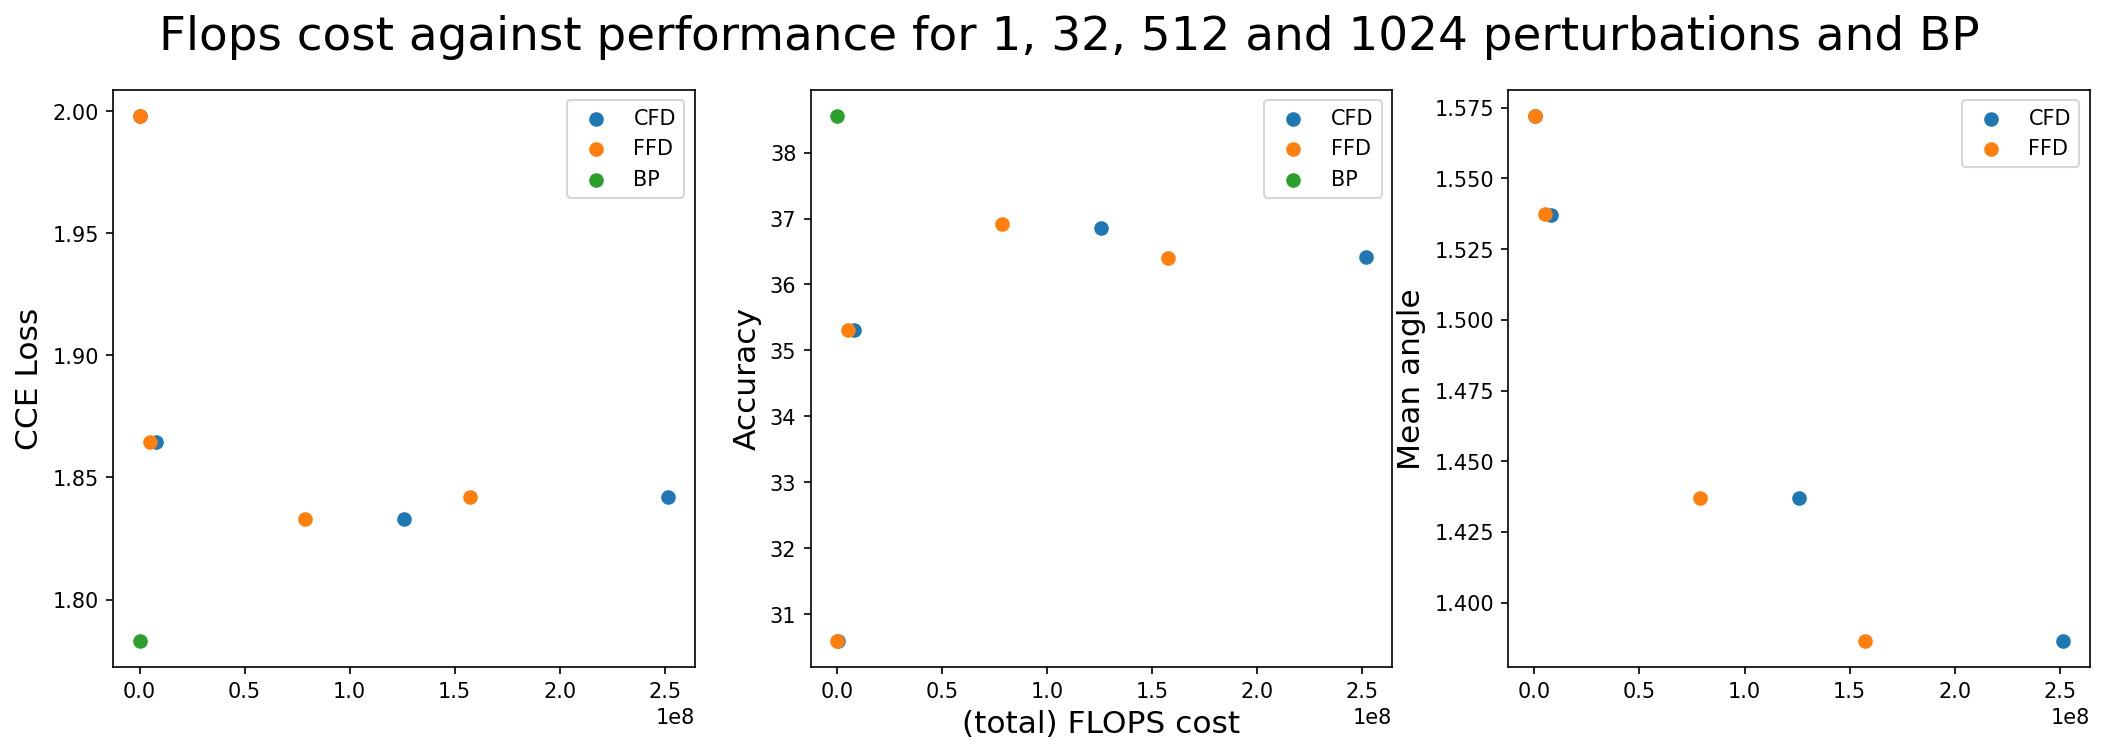

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(17, 5))
# loss, acc, angle, ose, Num_passes, algorithm
f.set_dpi(150)

Flops_vals_list = np.array(list(Flops_2.values()))

Flops_FFD_total = Flops_vals_list[:4][:, 2]

Flops_CFD_total = Flops_vals_list[4:-1][:, 2]
Flops_BP_total = Flops_vals_list[-1][2]




x = 15
plt.suptitle(
    "Flops cost against performance for 1, 32, 512 and 1024 perturbations and BP", fontsize=x * 1.5
)


axs[0].set_ylabel("CCE Loss", fontsize=x)
axs[0].scatter(
    Flops_CFD_total,
    CFD_stats[0][:, -1].reshape((4, -1)).mean(axis=1),
    label="CFD",
)
axs[0].scatter(
    Flops_FFD_total,
    FFD_stats[0][:, -1].reshape((4, -1)).mean(axis=1),
    label="FFD",
)


axs[0].scatter(
    Flops_BP_total,
    BP_CIFAR10_stats[0][:, -1].mean(),
    label="BP",
)

axs[0].legend(loc="upper right")

axs[1].scatter(
    Flops_CFD_total,
    CFD_stats[1][:, -1].reshape((4, -1)).mean(axis=1),
    label="CFD",
)

axs[1].scatter(
    Flops_FFD_total,
    FFD_stats[1][:, -1].reshape((4, -1)).mean(axis=1),
    label="FFD",
)

axs[1].scatter(
    Flops_BP_total,
    BP_CIFAR10_stats[1][:, -1].mean(),
    label="BP",
)

axs[1].set_xlabel("(total) FLOPS cost", fontsize=x)
axs[1].set_ylabel("Accuracy", fontsize=x)
axs[1].legend(loc="upper right")

axs[2].scatter(
    Flops_CFD_total,
    CFD_stats[2].mean(axis=1).reshape((4, -1)).mean(axis=1),
    label="CFD",
)

axs[2].scatter(
    Flops_FFD_total,
    FFD_stats[2].mean(axis=1).reshape((4, -1)).mean(axis=1),
    label="FFD",
)


axs[2].set_ylabel("Mean angle", fontsize=x)

axs[2].legend(loc="upper right")


plt.show()

##### Plot FLOPS backwards

In [30]:
print(Flops_vals_list[:4])
print(Flops_vals_list[4:-1])

[[   153620     30730    184350]
 [  3010890   1966720   4977610]
 [ 47252490  31467520  78720010]
 [ 94443530  62935040 157378570]]
[[   184350     30730    215080]
 [  5898890   1966720   7865610]
 [ 94382090  31467520 125849610]
 [188764170  62935040 251699210]]


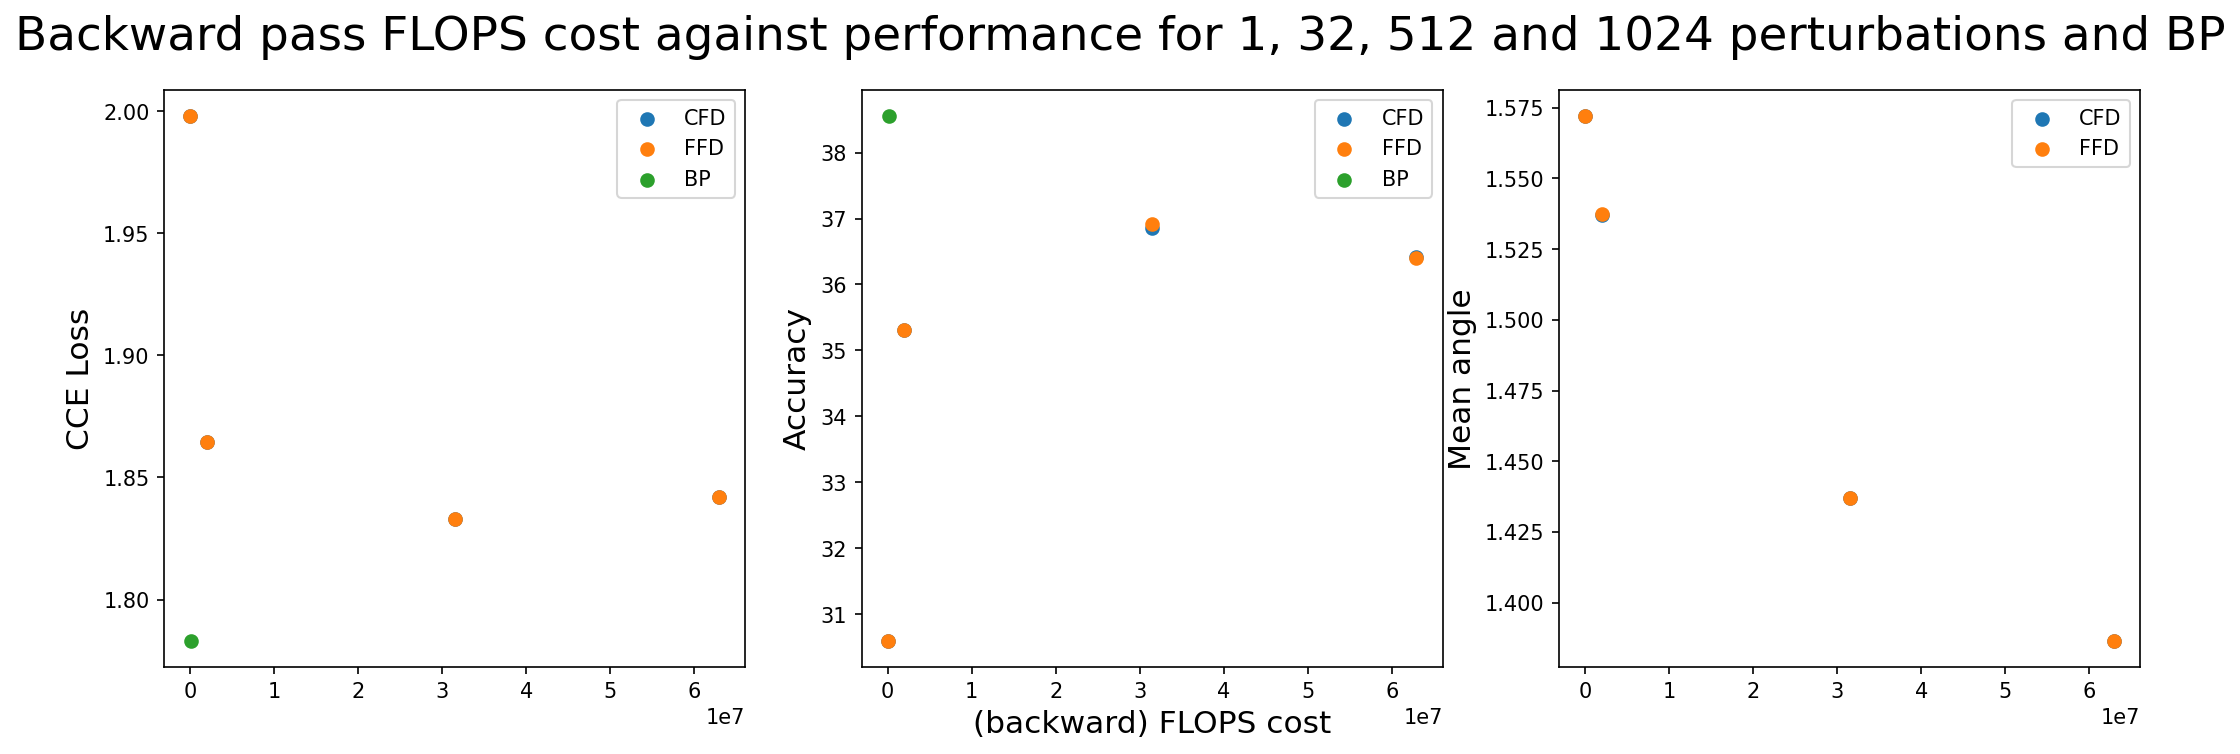

In [68]:
f, axs = plt.subplots(1, 3, figsize=(17, 5))
# loss, acc, angle, ose, Num_passes, algorithm
f.set_dpi(150)

Flops_vals_list = np.array(list(Flops_2.values()))

Flops_FFD_back = Flops_vals_list[:4][:, 1]

Flops_CFD_back = Flops_vals_list[4:-1][:, 1]
Flops_BP_back = Flops_vals_list[-1][1]


x = 15
plt.suptitle(
    "Backward pass FLOPS cost against performance for 1, 32, 512 and 1024 perturbations and BP",
    fontsize=x * 1.5,
)


axs[0].set_ylabel("CCE Loss", fontsize=x)
axs[0].scatter(
    Flops_CFD_back,
    CFD_stats[0][:, -1].reshape((4, -1)).mean(axis=1),
    label="CFD",
)
axs[0].scatter(
    Flops_FFD_back,
    FFD_stats[0][:, -1].reshape((4, -1)).mean(axis=1),
    label="FFD",
)


axs[0].scatter(
    Flops_BP_total,
    BP_CIFAR10_test_stats[0][:, -1].mean(),
    label="BP",
)

axs[0].legend(loc="upper right")

axs[1].scatter(
    Flops_CFD_back,
    CFD_stats[1][:, -1].reshape((4, -1)).mean(axis=1),
    label="CFD",
)

axs[1].scatter(
    Flops_FFD_back,
    FFD_stats[1][:, -1].reshape((4, -1)).mean(axis=1),
    label="FFD",
)

axs[1].scatter(
    Flops_BP_total,
    BP_CIFAR10_test_stats[1][:, -1].mean(),
    label="BP",
)

axs[1].set_xlabel("(backward) FLOPS cost", fontsize=x)
axs[1].set_ylabel("Accuracy", fontsize=x)
axs[1].legend(loc="upper right")

axs[2].scatter(
    Flops_CFD_back,
    CFD_stats[2].mean(axis=1).reshape((4, -1)).mean(axis=1),
    label="CFD",
)

axs[2].scatter(
    Flops_FFD_back,
    FFD_stats[2].mean(axis=1).reshape((4, -1)).mean(axis=1),
    label="FFD",
)


axs[2].set_ylabel("Mean angle", fontsize=x)

axs[2].legend(loc="upper right")


plt.show()

In [ ]:
def plot_trajectory(
    Sweeps,
    metric_indexes,
    metric_names,
    task_name,
    group_selection: tuple = (3, [0, 1, 2]),
):
    """
    Sweeps : list
        List of arrays containing the results (accuracy, loss, angle etc.) of a Sweep

    metric_indexes : list
        List containing indexes, representing which tasks should be plotted

    metric_names : list
        List containing names of metrics

    task_name : str
        Which task was tried, like CIFAR10 or MNIST

    Group selection : tuple
        Tuple containing how many groups there are for plotting, and how many of those groups should be plotted

    """
    f, axs = plt.subplots(1, len(metric_indexes), figsize=(5 * len(metric_indexes), 5))
    f.set_dpi(400)
    x = np.linspace(1, 499, num=499)

    # Will need to

    for count, metric_index in enumerate(metric_indexes):
        for Sweep in Sweeps:
            algorithms = np.unique(Sweep[5])

            labels = np.array(
                [
                    "(" + algorithm + "): " + str(num_passes)
                    for num_passes in np.flip(np.unique(Sweep[4]))
                    for algorithm in algorithms
                ]
            )

            labels = labels[group_selection[1]]

            metric = (
                Sweep[metric_index]
                if algorithms[0].lower() == "bp"
                else np.array(np.split(Sweep[metric_index], group_selection[0], axis=0))
            )[group_selection[1]]

            metric = np.transpose(metric)
            mean = np.mean(
                metric, axis=1
            )  # metric is number of groups by number of runs by epochs
            q1 = np.percentile(metric, 25, axis=1)
            q3 = np.percentile(metric, 75, axis=1)
            axs[count].plot(x, mean, label=labels)

            for q in range(q1.shape[-1]):
                axs[count].fill_between(x, q1[:, q], q3[:, q], alpha=0.5, label="")

        axs[count].set_title(
            f"{metric_names[metric_index]} over training on test set for {task_name}"
        )
        axs[count].legend()
    plt.show()

In [ ]:
def plot_scatter(
    Sweeps,
    metric_indexes,
    metric_names,
    task_name,
    group_selection: tuple = (3, [0, 1, 2]),
):
    """
    Sweeps : list
        List of arrays containing the results (accuracy, loss, angle etc.) of a Sweep

    metric_indexes : list
        List containing indexes, representing which tasks should be plotted

    metric_names : list
        List containing names of metrics

    task_name : str
        Which task was tried, like CIFAR10 or MNIST

    Group selection : tuple
        Tuple containing how many groups there are for plotting, and how many of those groups should be plotted

    """
    f, axs = plt.subplots(1, len(metric_indexes), figsize=(5 * len(metric_indexes), 5))
    f.set_dpi(400)
    for count, metric_index in enumerate(metric_indexes):
        for Sweep in Sweeps:
            algorithms = np.unique(Sweep[5])
            num_runs = Sweep[4]

            labels = np.array(
                [
                    "(" + algorithm + "): " + str(num_passes)
                    for num_passes in np.flip(np.unique(Sweep[4]))
                    for algorithm in algorithms
                ]
            )
            print(labels)
            labels = labels[group_selection[1]]
            print(len(Sweep[metric_index]))
            print(group_selection[0])
            metric = (
                Sweep[metric_index]
                if algorithms[0].lower() == "bp"
                else np.array(np.split(Sweep[metric_index], group_selection[0], axis=0))
            )[group_selection[1]]

            metric = np.transpose(metric)
            mean = np.mean(
                metric, axis=1
            )  # metric is number of groups by number of runs by epochs

            axs[count].scatter(num_runs, mean, label=labels)

        axs[count].set_title(
            f"{metric_names[metric_index]} over training on test set for {task_name}"
        )
        axs[count].legend()
    plt.show()

['(CFD): 64.0' '(CFD): 62.0' '(CFD): 60.0' '(CFD): 58.0' '(CFD): 56.0'
 '(CFD): 54.0' '(CFD): 52.0' '(CFD): 50.0' '(CFD): 48.0' '(CFD): 46.0'
 '(CFD): 44.0' '(CFD): 42.0' '(CFD): 40.0' '(CFD): 38.0' '(CFD): 36.0'
 '(CFD): 34.0' '(CFD): 32.0' '(CFD): 30.0' '(CFD): 28.0' '(CFD): 26.0'
 '(CFD): 24.0' '(CFD): 22.0' '(CFD): 20.0' '(CFD): 18.0' '(CFD): 16.0'
 '(CFD): 14.0' '(CFD): 12.0' '(CFD): 10.0' '(CFD): 8.0' '(CFD): 6.0'
 '(CFD): 4.0' '(CFD): 2.0']
32


ValueError: array split does not result in an equal division

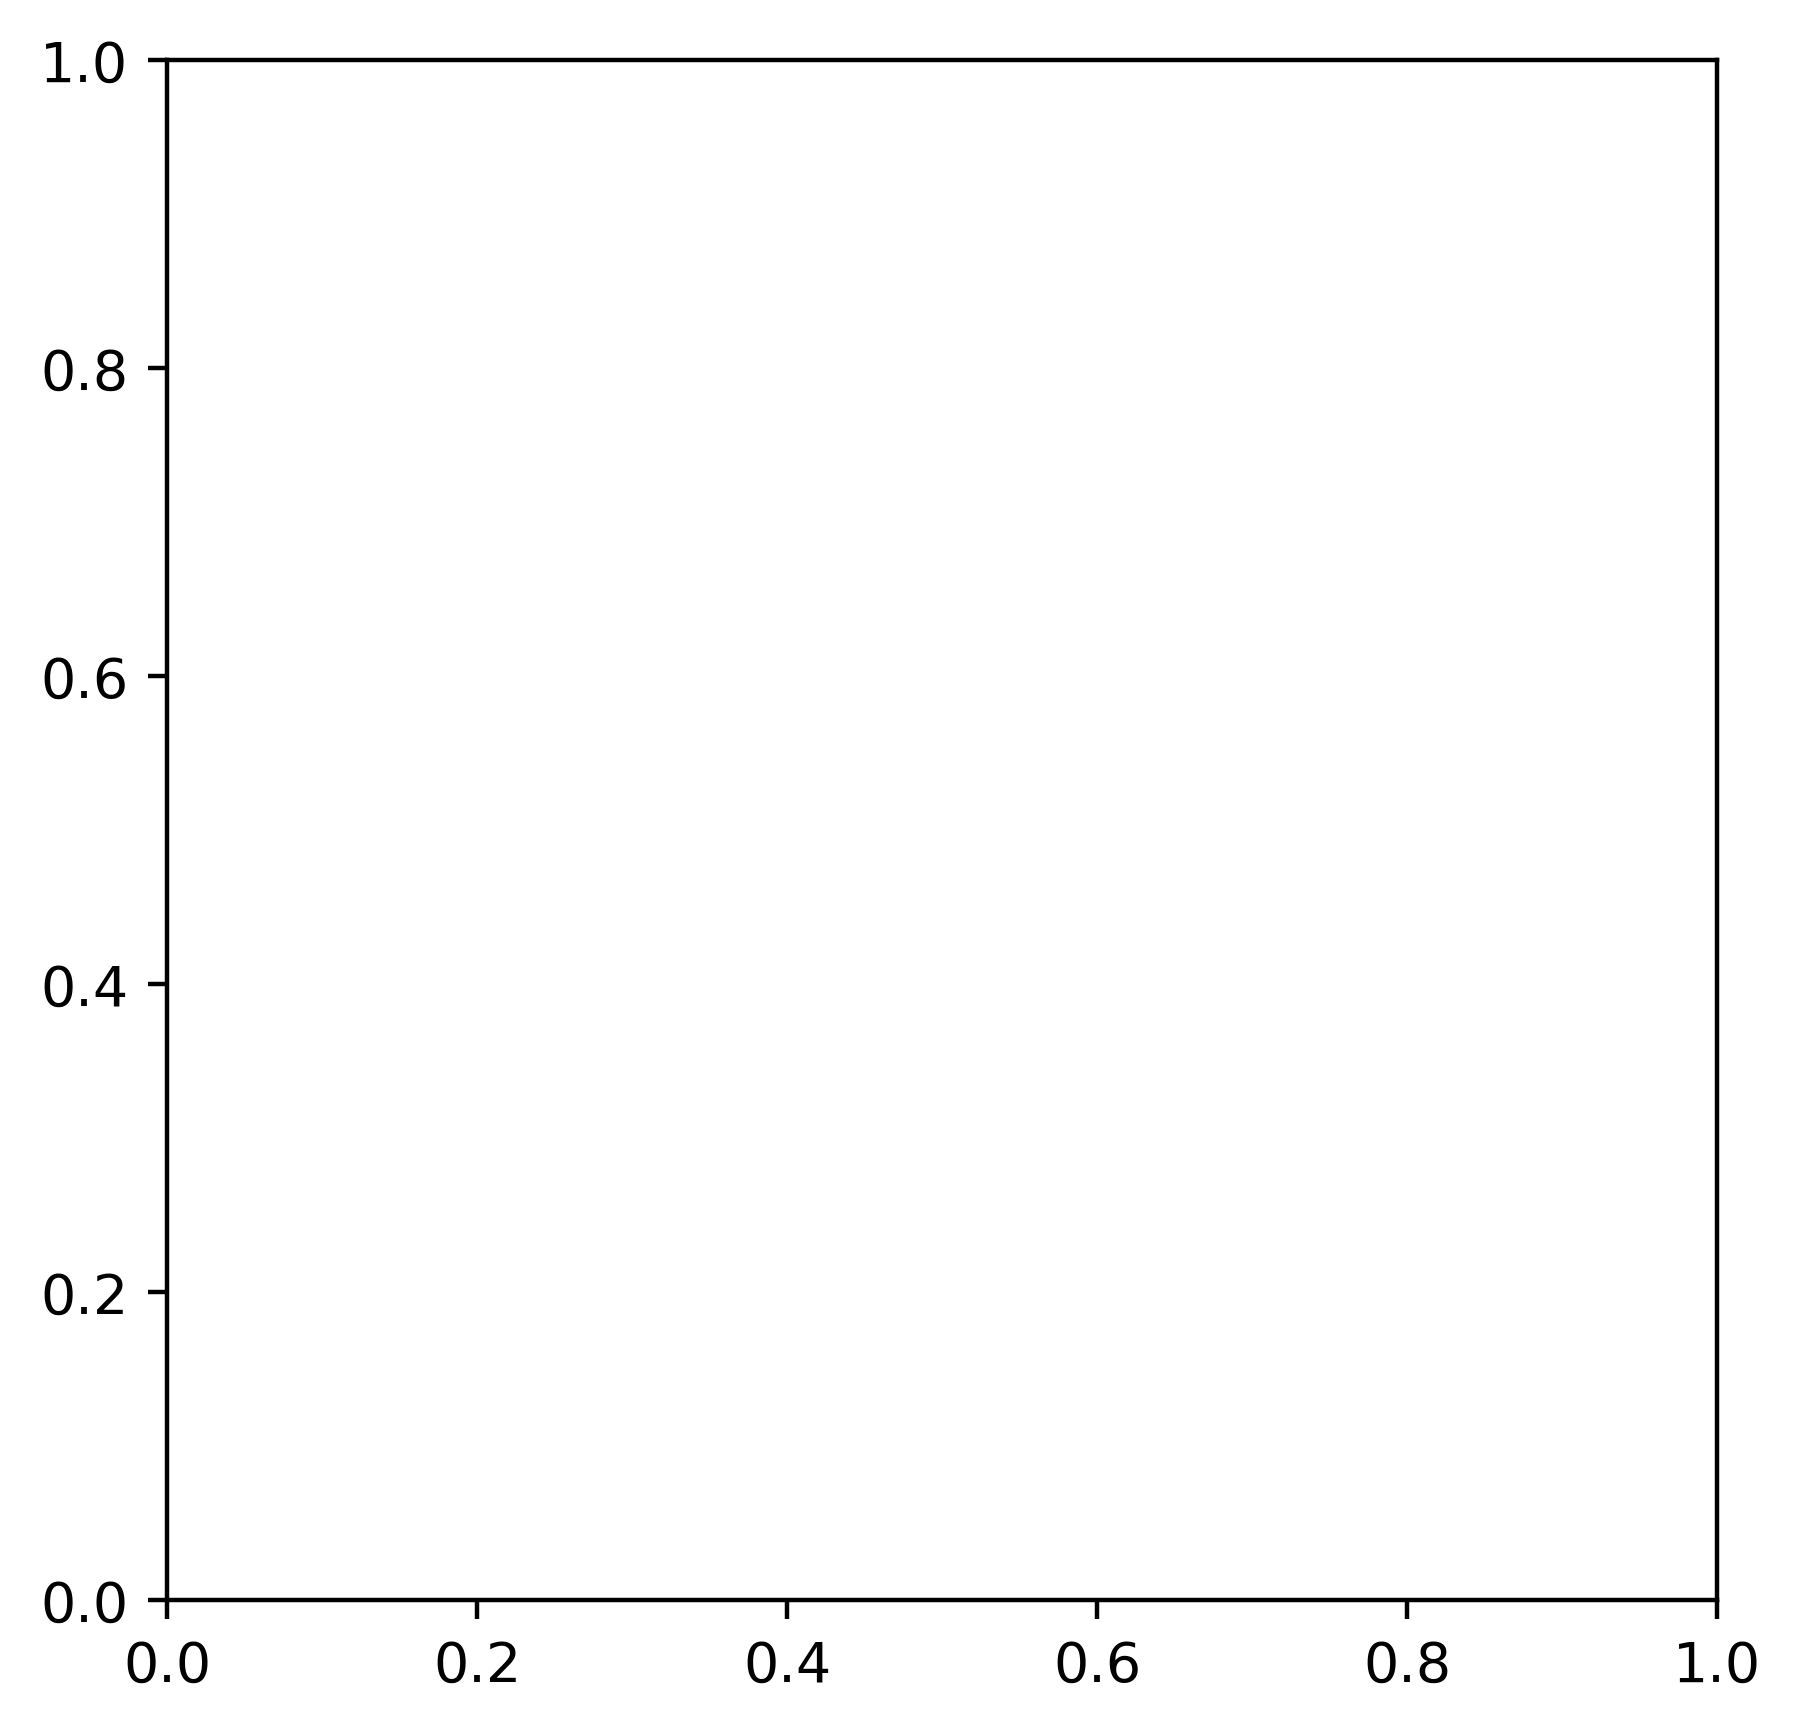

In [ ]:
sweeps = [CFD_CIFAR10_increasing_perts_stats,
CFD_CIFAR10_increasing_perts2_stats,
FFD_CIFAR10_increasing_perts_stats]

indexes = [0]
group_selection = (32, np.linspace(1,32,32))

plot_scatter(sweeps, indexes, "CIFAR10", group_selection)

['FFD']


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

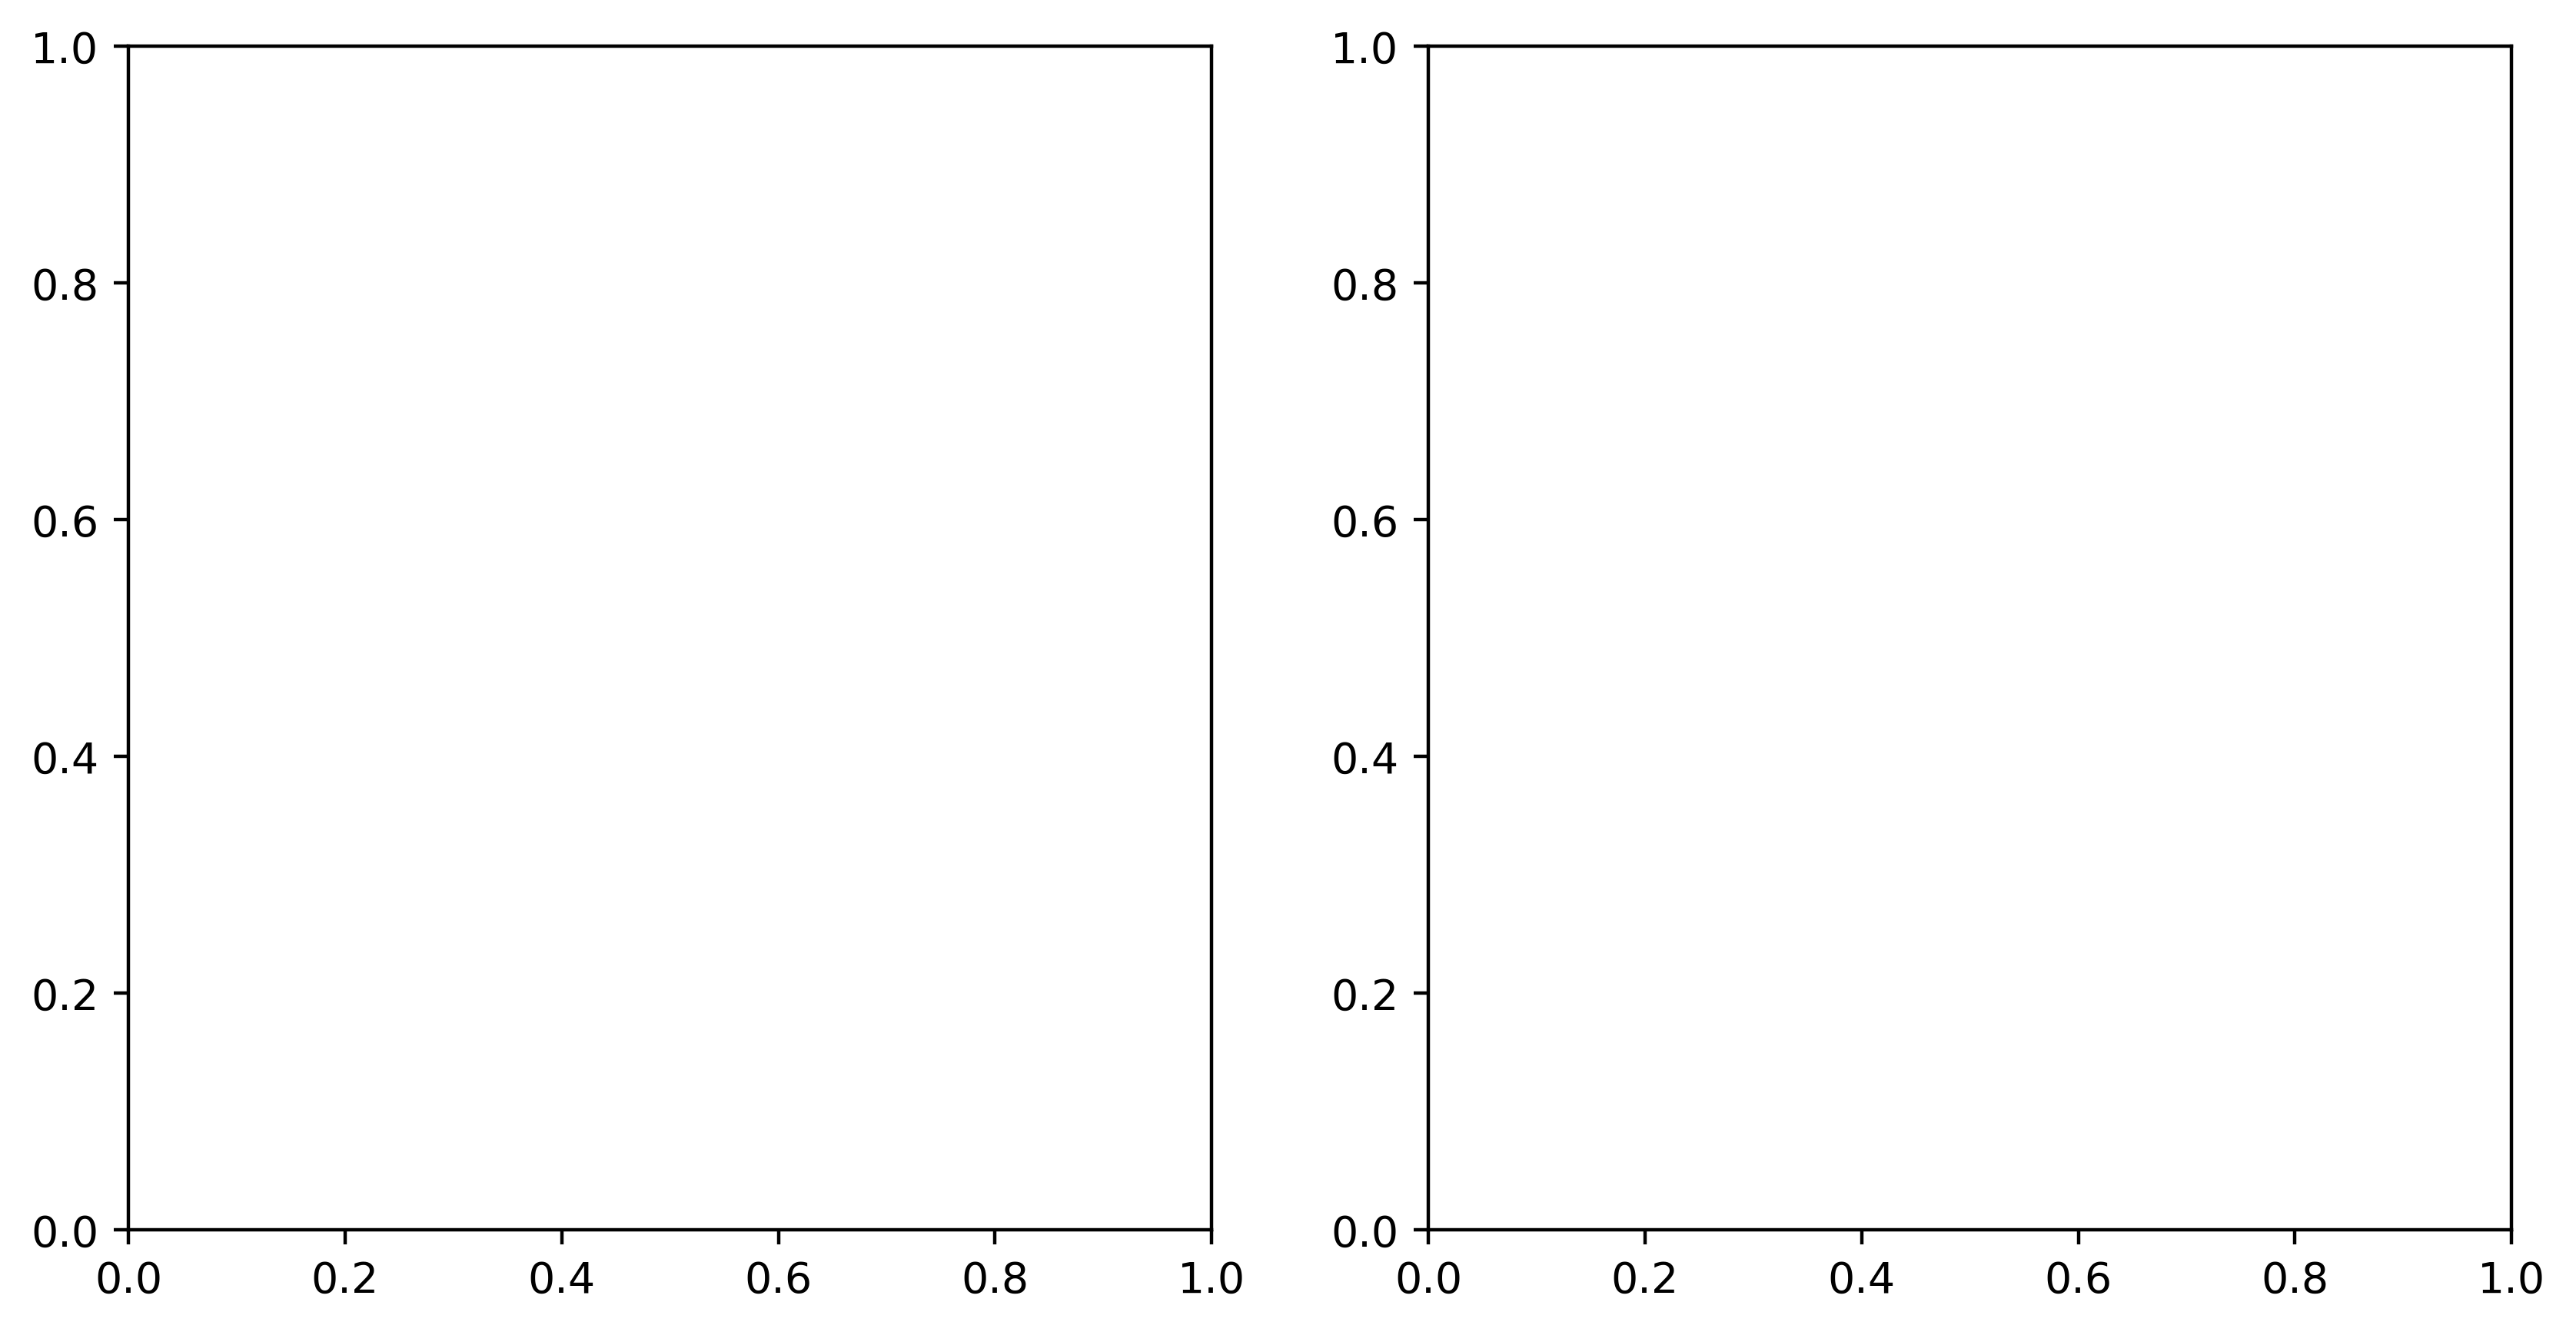

In [ ]:
Sweeps = [
    Meta_FFD_CIFAR10_stats,
    FFD_CIFAR10_stats,
]
indexes = [0, 1]
group_selection = (3, [2])
plot_trajectory(Sweeps, indexes, metric_names, "CIFAR10", group_selection)

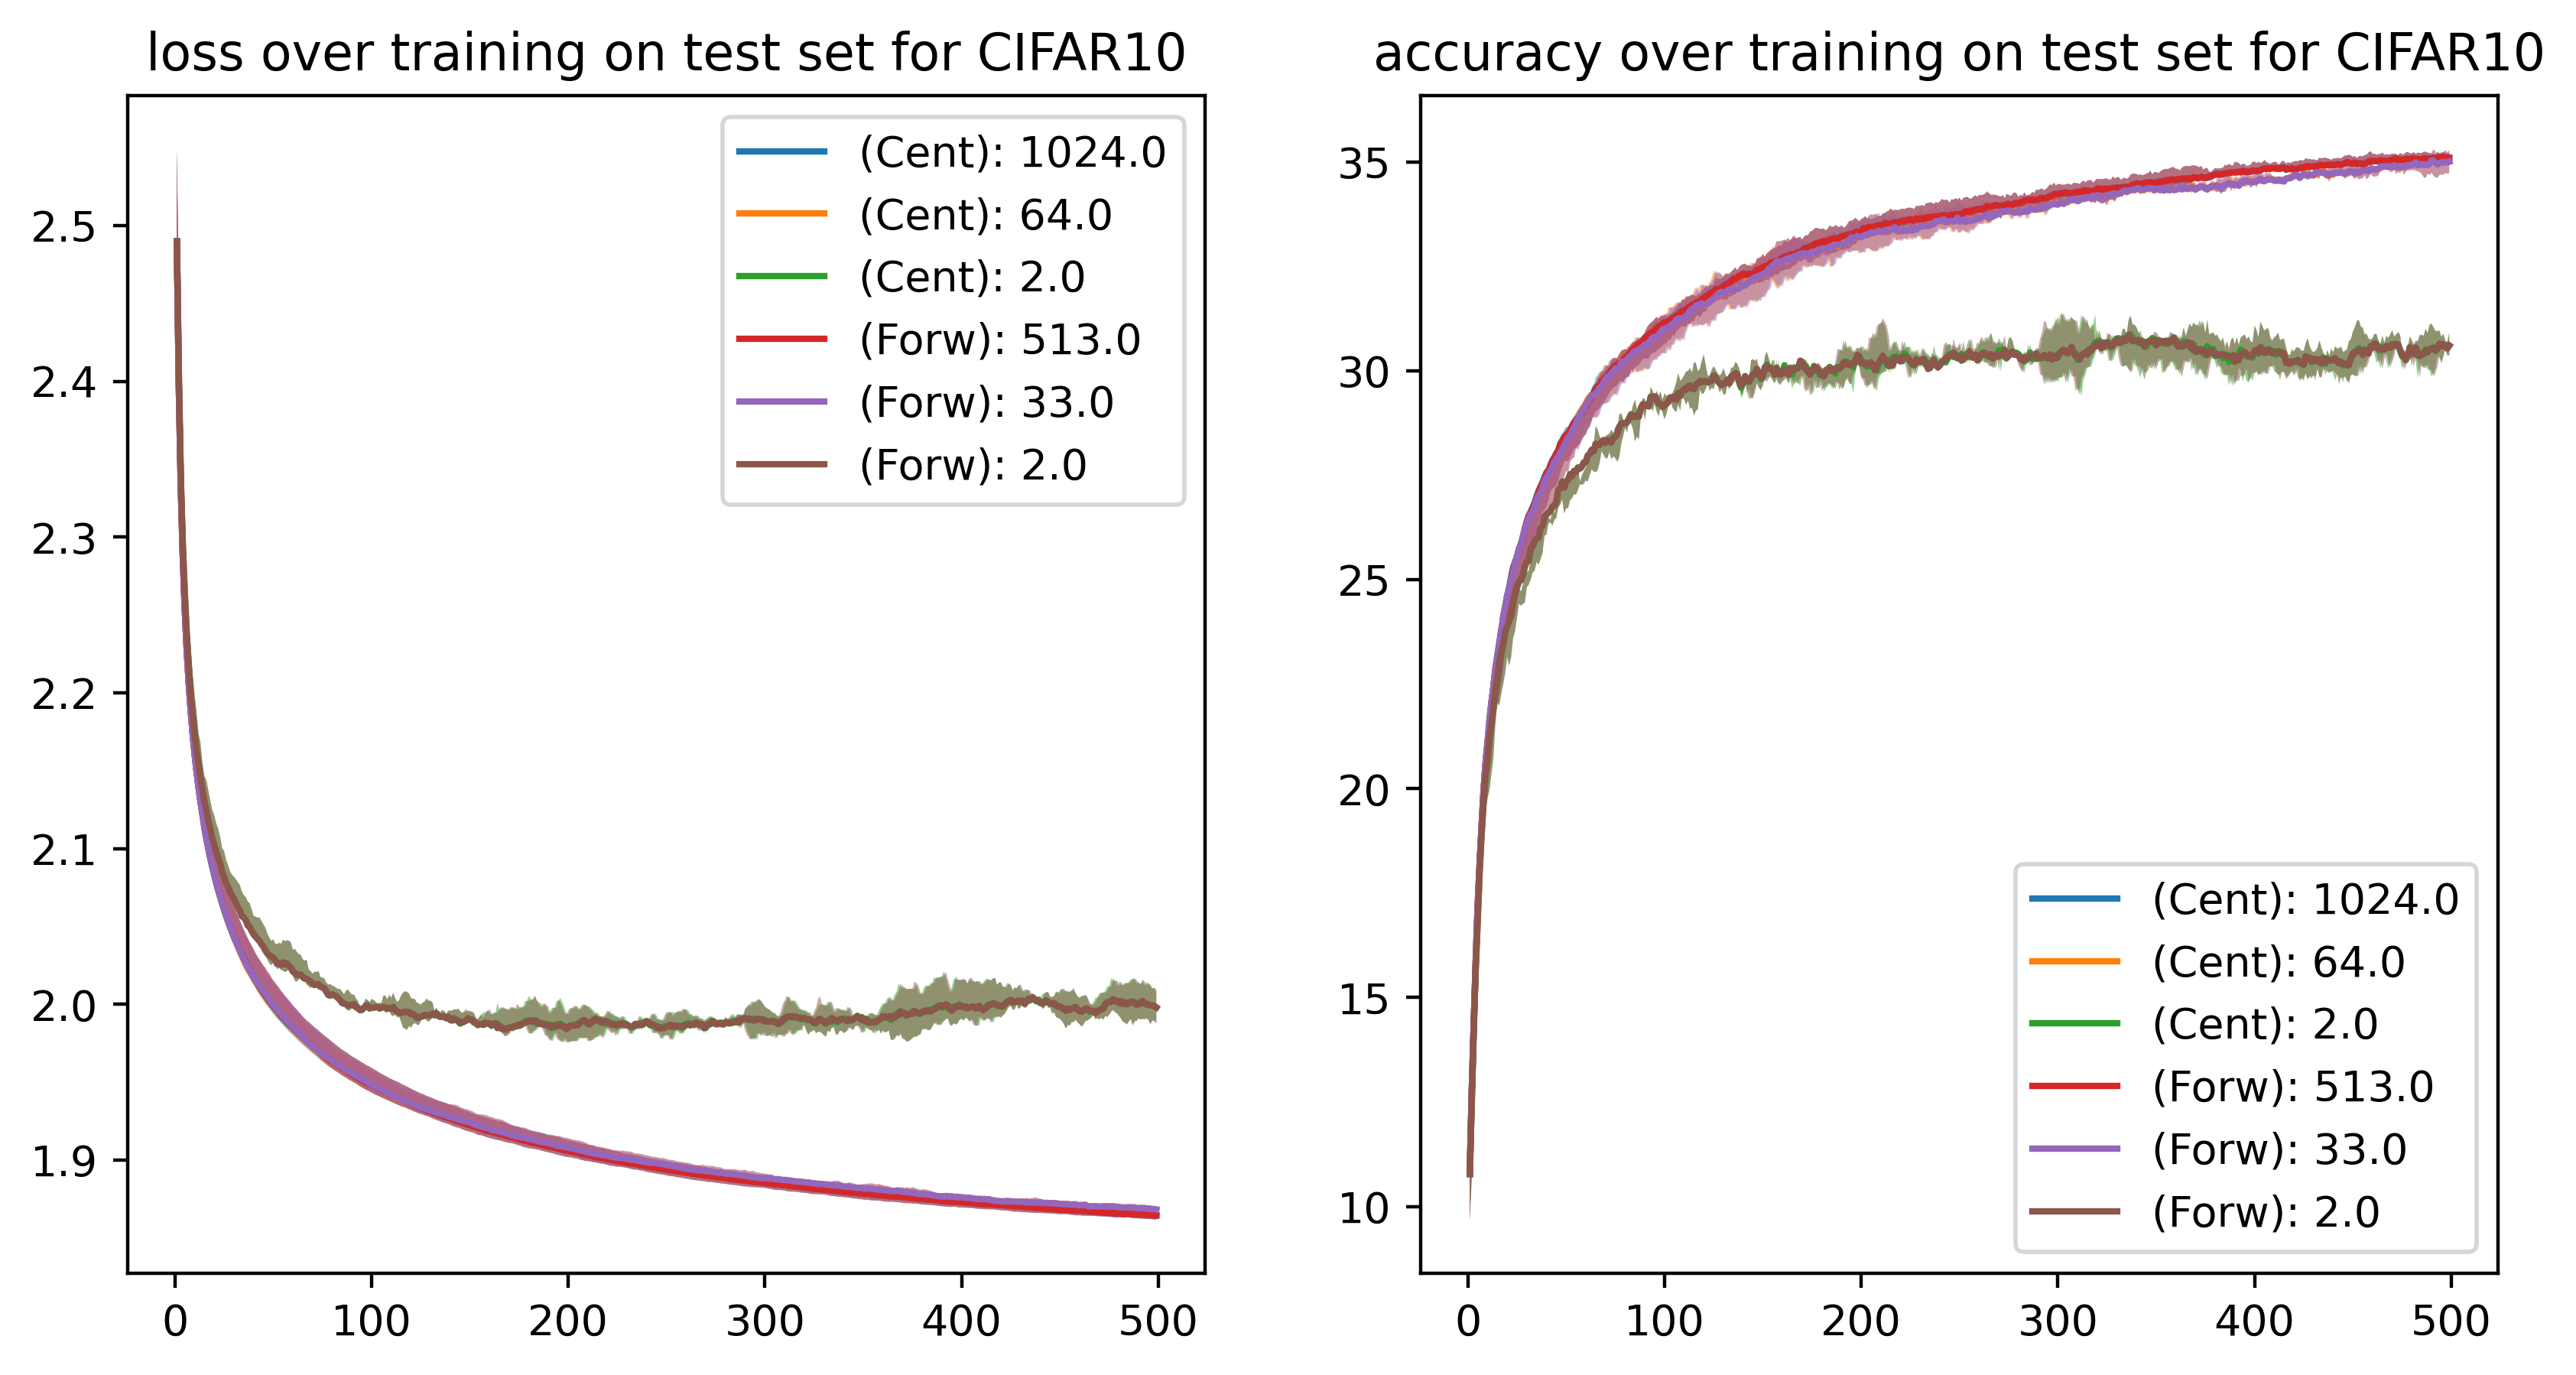

In [ ]:
Sweeps = [CFD_CIFAR10_stats, FFD_CIFAR10_stats, ]
indexes = [0,1]
plot_trajectory(Sweeps, indexes, metric_names, "CIFAR10")

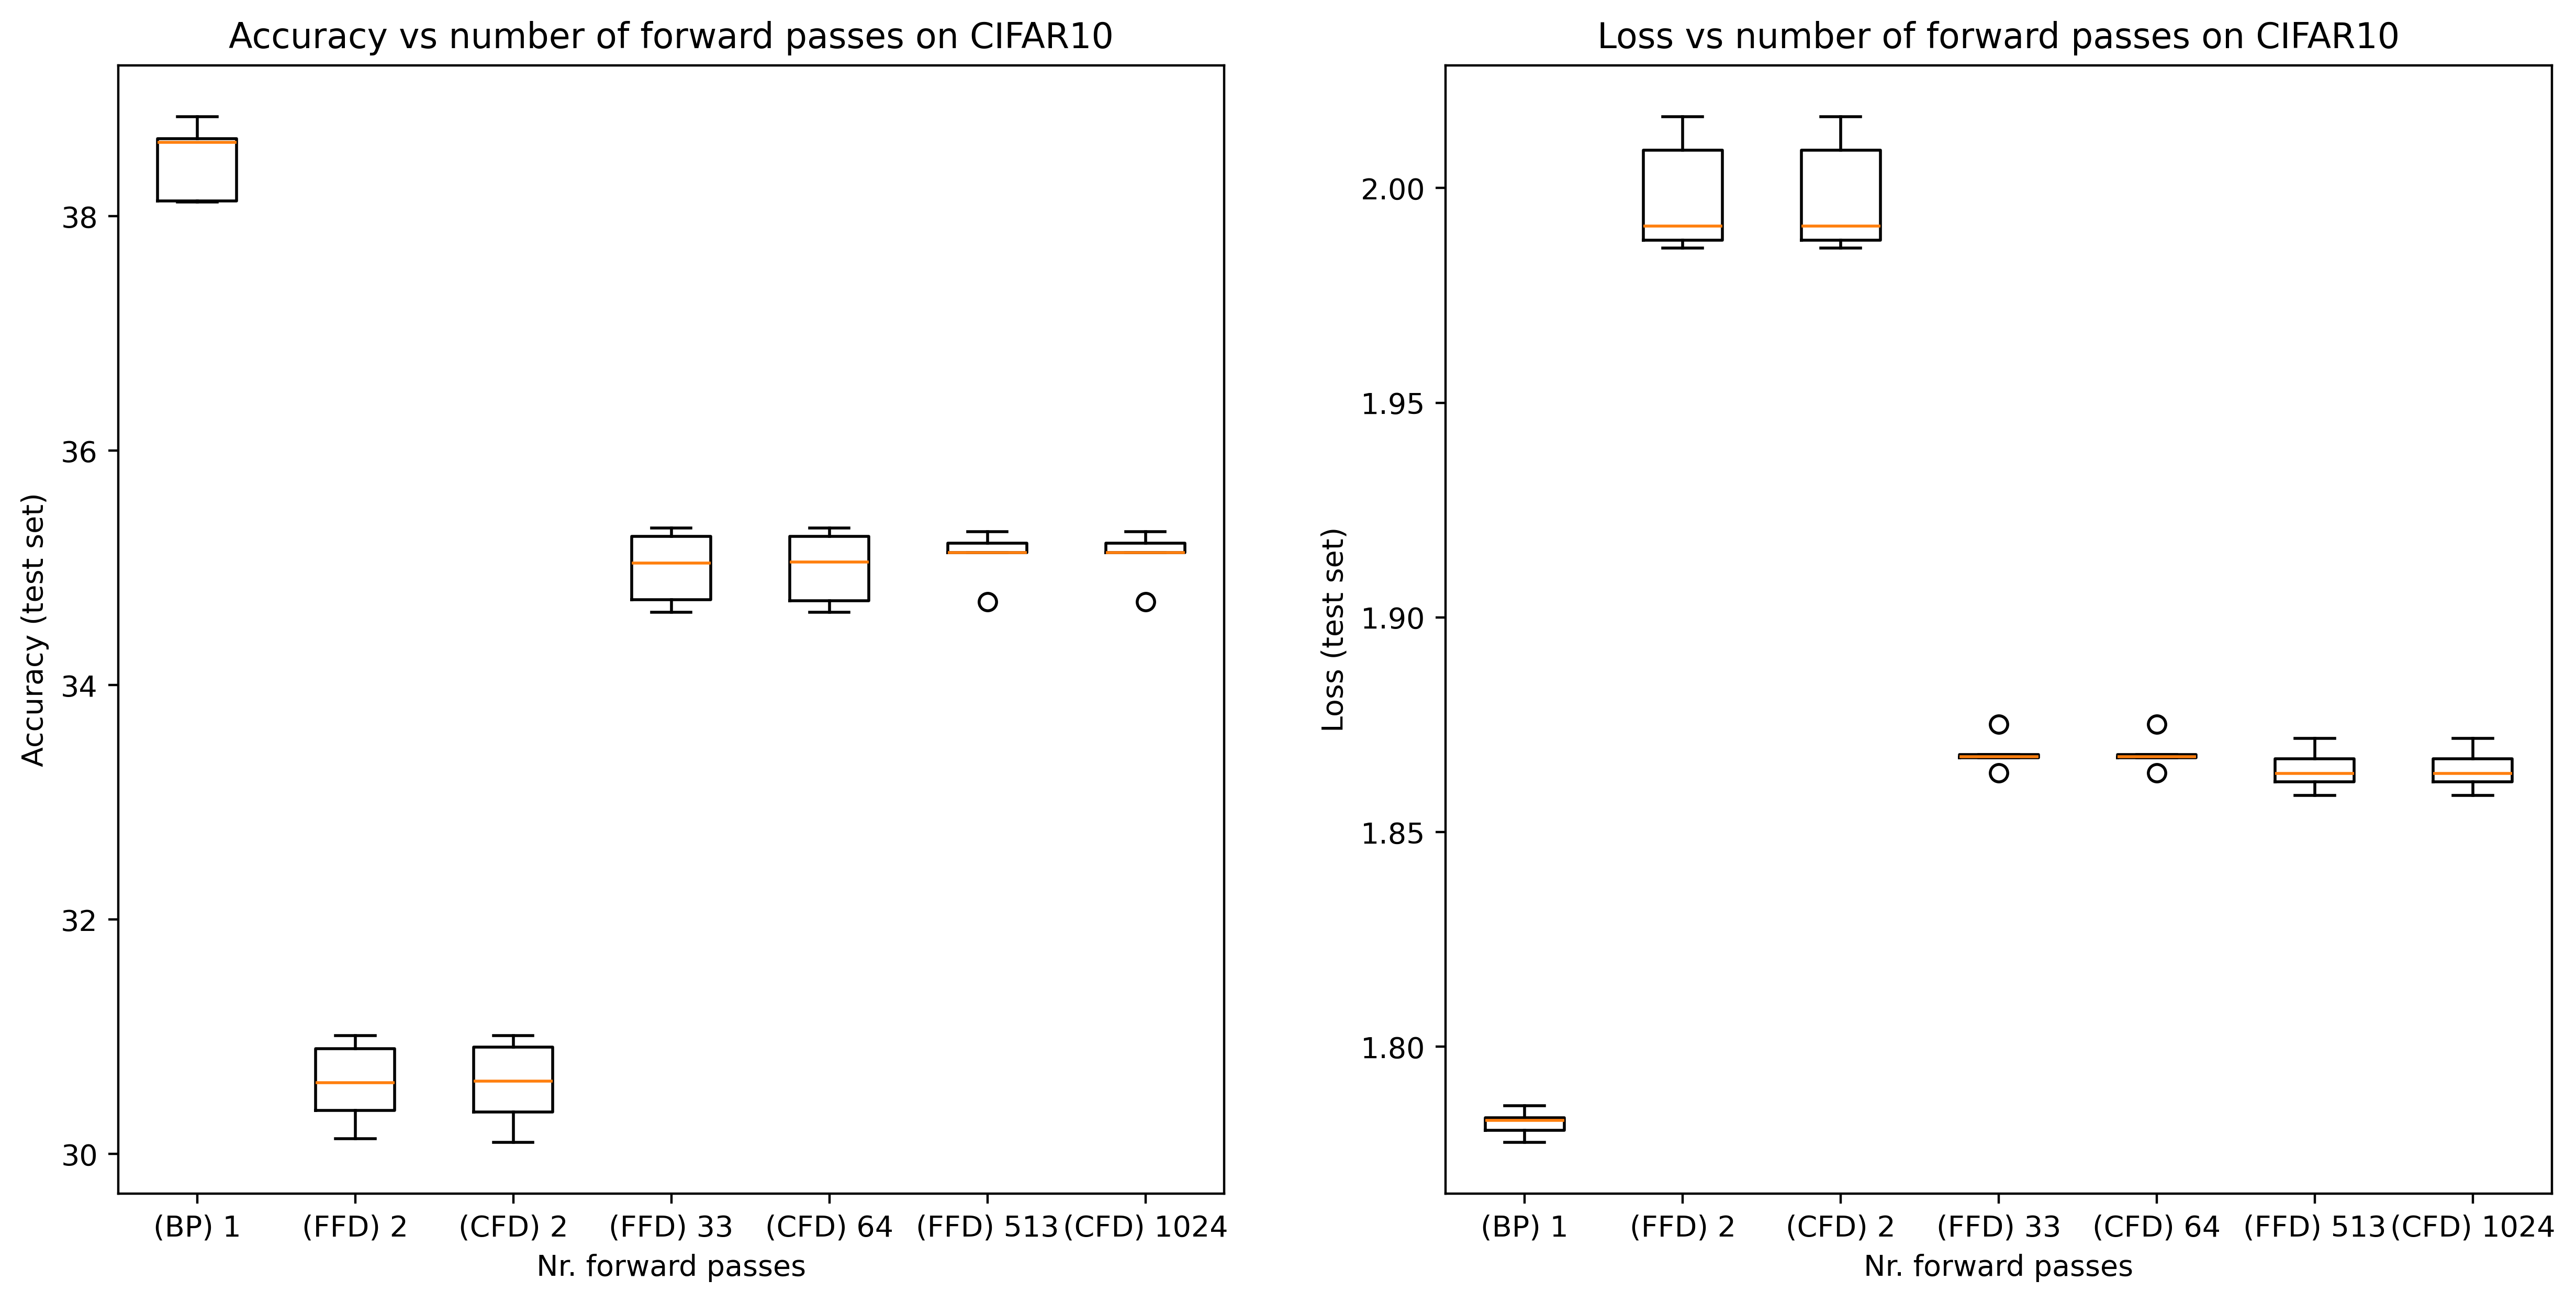

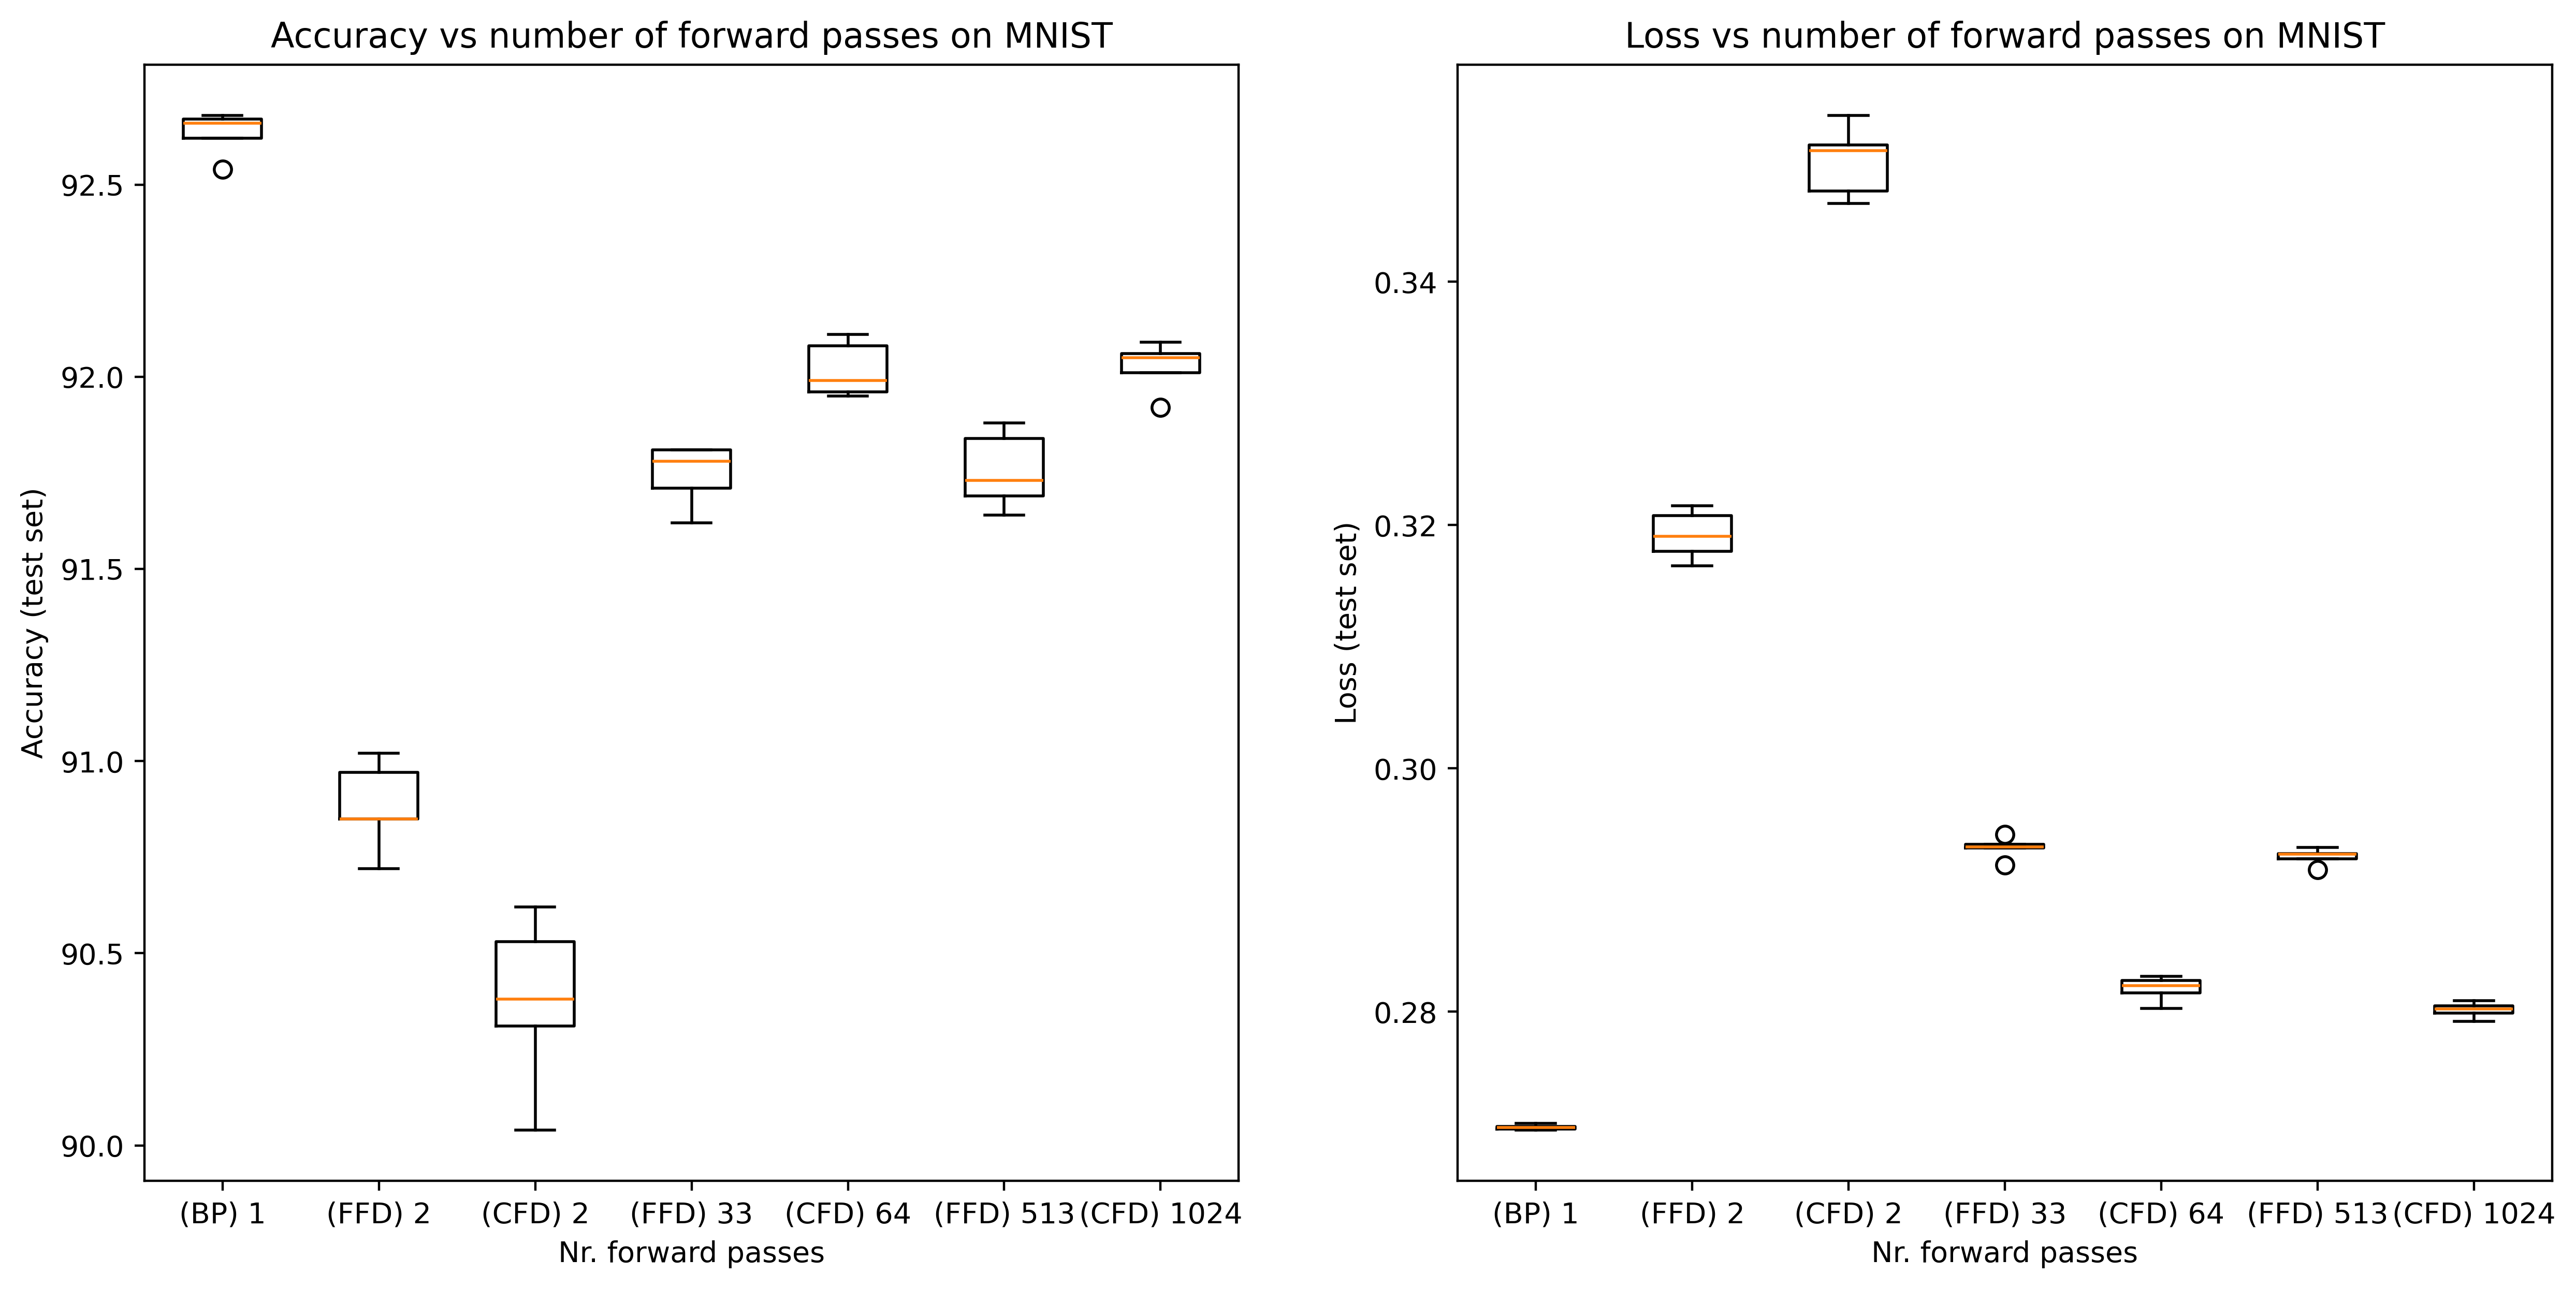

In [ ]:
make_boxplots(FFD_CIFAR10_stats, CFD_CIFAR10_stats, BP_CIFAR10_stats, "CIFAR10")
make_boxplots(FFD_MNIST_stats, CFD_MNIST_stats, BP_MNIST_stats, "MNIST")

# very surprising that they should be so similar, but it is the case:
# https://wandb.ai/brai-lab/MetaWP/runs/18y6z1jh/logs - ffd
# https://wandb.ai/brai-lab/MetaWP/runs/eh2isu8h/logs - cfd - in the last epoch, the loss is only smaller by 1e-7

### One layer 1, 2, 32, 512, 1024 perturbations experiment (best lr for 1 perturbation)

### Three layer 1, 32, 512 perturbations performance